In [76]:
import learn2learn as l2l
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pickle
import sys
import argparse
import os
from run_MAML_04 import test2 as test_maml


sys.path.insert(1, "..")

from ts_dataset import TSDataset
from base_models import LSTMModel, FCN
from metrics import torch_mae as mae
import copy
from pytorchtools import EarlyStopping, to_torch
from eval_base_models import test, train, freeze_model
from torch.utils.data import Dataset, DataLoader
from ts_dataset import DomainTSDataset, SimpleDataset
from sklearn.manifold import TSNE

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pickle
import sys
import matplotlib.pyplot as plt
from collections import OrderedDict
import argparse
import os
import learn2learn as l2l
from multimodallearner import get_task_encoder_input
from multimodallearner import LSTMDecoder, Lambda, MultimodalLearner
from metalearner import MetaLearner
from meta_base_models import LinearModel, Task
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import copy
import json

In [77]:
meta_info = {"POLLUTION": [5, 50, 14],
             "HR": [32, 50, 13],
             "BATTERY": [20, 50, 3] }

output_directory = "output/"
horizon = 10
output_dim = 1

#dataset_name = "HR"
#experiment_id = "9_COMPARISON_2"
#experiment_id = "10_COMPARISON_2"
#experiment_id = "13_COMPARISON_2"

#dataset_name = "POLLUTION"
#experiment_id = "1_COMPARISON_2"
#experiment_id = "5_COMPARISON_1"

dataset_name = "BATTERY"
#experiment_id = "17_COMPARISON_1"
experiment_id = "21_COMPARISON"

#load_model_file = "9_COMPARISON_2_model.pt"
lower_trial = 0
upper_trial = 3
learning_rate = 0.0001
meta_learning_rate = 0.005
adaptation_steps = 1
batch_size = 20
model_name = "LSTM"
is_test = 1
patience_stopping = 20
epochs = 1000
noise_level = 0.0
noise_type = "additive"

params = {'batch_size': batch_size,
      'shuffle': True,
      'num_workers': 0}

assert model_name in ("FCN", "LSTM"), "Model was not correctly specified"
assert dataset_name in ("POLLUTION", "HR", "BATTERY")

window_size, task_size, input_dim = meta_info[dataset_name]

train_data = pickle.load(  open( "../../Data/TRAIN-"+dataset_name+"-W"+str(window_size)+"-T"+str(task_size)+"-NOML.pickle", "rb" ) )
train_data_ML = pickle.load( open( "../../Data/TRAIN-"+dataset_name+"-W"+str(window_size)+"-T"+str(task_size)+"-ML.pickle", "rb" ) )
validation_data = pickle.load( open( "../../Data/VAL-"+dataset_name+"-W"+str(window_size)+"-T"+str(task_size)+"-NOML.pickle", "rb" ) )
validation_data_ML = pickle.load( open( "../../Data/VAL-"+dataset_name+"-W"+str(window_size)+"-T"+str(task_size)+"-ML.pickle", "rb" ) )
test_data = pickle.load( open( "../../Data/TEST-"+dataset_name+"-W"+str(window_size)+"-T"+str(task_size)+"-NOML.pickle", "rb" ) )
test_data_ML = pickle.load( open( "../../Data/TEST-"+dataset_name+"-W"+str(window_size)+"-T"+str(task_size)+"-ML.pickle", "rb" ) )

In [78]:

trial = 0
output_directory = "../../Models/"+dataset_name+"_"+model_name+"_MMAML/"+str(trial)+"/"

save_model_file_encoder = output_directory + experiment_id + "_encoder_model.pt"
save_model_file_ = output_directory + experiment_id + "_model.pt"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = LSTMModel( batch_size=batch_size, seq_len = window_size, input_dim = input_dim, n_layers = 2, hidden_dim = 120, output_dim =1)
output_layer = nn.Linear(120, 1)

n_layers_task_net = 2
n_layers_task_encoder = 1
n_layers_task_decoder = 1

hidden_dim_task_net = 120
hidden_dim_encoder = 120
hidden_dim_decoder = 120

input_dim_task_net = input_dim
input_dim_task_encoder = input_dim + 1
output_dim_task_net = 1
output_dim_task_decoder = input_dim + 1
output_dim = 1
modulate_task_net = True

task_net = LSTMModel(batch_size=batch_size,
                     seq_len=window_size,
                     input_dim=input_dim_task_net,
                     n_layers=n_layers_task_net,
                     hidden_dim=hidden_dim_task_net,
                     output_dim=output_dim_task_net)

task_encoder = LSTMModel(batch_size=batch_size,
                         seq_len=task_size,
                         input_dim=input_dim_task_encoder,
                         n_layers=n_layers_task_encoder,
                         hidden_dim=hidden_dim_encoder,
                         output_dim=1)

task_decoder = LSTMDecoder(batch_size=1,
                           n_layers=n_layers_task_decoder,
                           seq_len=task_size,
                           output_dim=output_dim_task_decoder,
                           hidden_dim=hidden_dim_encoder,
                           latent_dim=hidden_dim_decoder,
                           device=device)
lmbd = Lambda(hidden_dim_encoder, hidden_dim_task_net)

multimodal_learner = MultimodalLearner(task_net, task_encoder, task_decoder, lmbd, modulate_task_net)

multimodal_learner.cuda()
model.cuda()
output_layer.cuda()

#output_layer.load_state_dict(torch.load(save_model_file_))

maml = l2l.algorithms.MAML(output_layer, lr=learning_rate, first_order=False)
multimodal_learner.load_state_dict(torch.load(save_model_file_encoder))
maml.load_state_dict(torch.load(save_model_file_))

total_tasks_test = len(test_data_ML)
error_list =  []
parameters_list = []
domain_list = []
error_mean = []
activations_list = []

learner = maml.clone()  # Creates a clone of model
learner.cuda()
count = 0.0


input_dim = test_data_ML.x.shape[-1]
window_size = test_data_ML.x.shape[-2]
output_dim = test_data_ML.y.shape[-1]

if is_test:
    step = total_tasks_test//100

else:
    step = 1

step = 1 if step == 0 else step
step = 1
max_tasks = (total_tasks_test-horizon-1)


temp_params = []
for params in maml.parameters():

    temp_params.append(params.cpu().detach().numpy()[0])
params = np.concatenate([temp_params[0], np.array([temp_params[1]])])
parameters_list.append(list(params))
domain_list.append(test_data_ML.file_idx[-1])
idx_list = [0]
modulation_output_list = []
encoding_list =[]

for task_id in range(0,max_tasks , step):

    temp_file_idx = test_data_ML.file_idx[task_id:task_id+horizon+1]
    if(len(np.unique(temp_file_idx))>1):
        continue

    idx_list.append(test_data_ML.file_idx[task_id])
    #model = LSTMModel( batch_size=None, seq_len = None, input_dim = input_dim, n_layers = 2, hidden_dim = 120, output_dim =1)

    learner = maml.clone() 

    x_spt, y_spt = test_data_ML[task_id]
    x_qry = test_data_ML.x[(task_id+1):(task_id+1+horizon)].reshape(-1, window_size, input_dim)
    y_qry = test_data_ML.y[(task_id+1):(task_id+1+horizon)].reshape(-1, output_dim)

    
    task = get_task_encoder_input(SimpleDataset(x=x_spt[np.newaxis,:], y=y_spt[np.newaxis,:]))
    task = to_torch(task)

    x_spt, y_spt = to_torch(x_spt), to_torch(y_spt)
    x_qry = to_torch(x_qry)
    y_qry = to_torch(y_qry)


    for step in range(adaptation_steps):

        x_encoding, _ = multimodal_learner(x_spt, task, output_encoding = True)   
        pred = learner(x_encoding)
        error = mae(pred, y_spt)
        learner.adapt(error)

    encoding = multimodal_learner.task_encoder.encoder(task)
    modulation = multimodal_learner.modulation_layer(encoding)
    modulation_output_list.append(modulation.cpu().detach().numpy())
    encoding_list.append(encoding.cpu().detach().numpy())
    
    error_mean.append(np.mean(error.cpu().detach().numpy()))
    temp_params = []
    for params in maml.parameters():

        temp_params.append(params.cpu().detach().numpy()[0])
    params = np.concatenate([temp_params[0], np.array([temp_params[1]])])
    parameters_list.append(list(params))
    domain_list.append(test_data_ML.file_idx[task_id])
    activations_list.append(model.encoder(x_spt).cpu().detach().numpy()[np.newaxis, :])
    
    

In [79]:
activations = np.concatenate(activations_list)
activations.shape

(5187, 50, 120)

In [80]:
import matplotlib.pyplot as plt
X_embedded = TSNE(n_components=2).fit_transform(parameters_list)



Text(0.5, 1.0, 'BATTERY-MAML-PARAMETERS-ALL-DOMAIN')

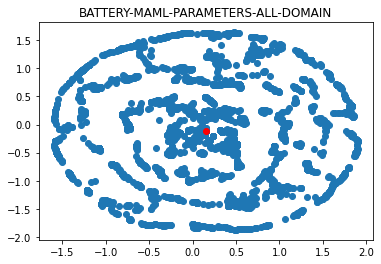

In [81]:
%matplotlib inline
plt.scatter(X_embedded[:,0], X_embedded[:,1])
plt.scatter(X_embedded[0,0], X_embedded[0,1], c="red")
name = dataset_name+"-MAML-PARAMETERS-ALL-DOMAIN"
plt.title(name)
#plt.savefig("../../Results/figures/"+name+".png")

In [82]:
np.vstack(modulation_output_list).shape

(5187, 240)

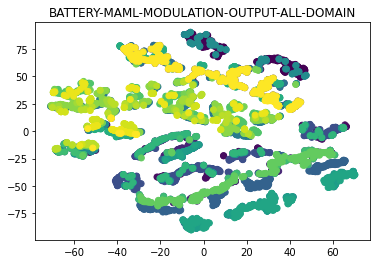

In [83]:
import matplotlib.pyplot as plt
X_embedded = TSNE(n_components=2).fit_transform(np.vstack(modulation_output_list))

%matplotlib inline
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=np.array(idx_list[1:]))
#plt.scatter(X_embedded[0,0], X_embedded[0,1], c="red")
name = dataset_name+"-MAML-MODULATION-OUTPUT-ALL-DOMAIN"
plt.title(name)
plt.savefig("../../Results/figures/"+name+".jpg")

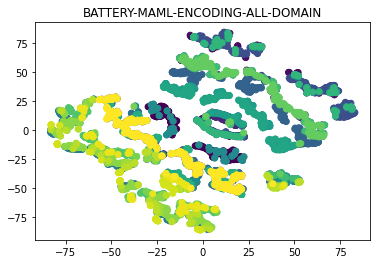

In [84]:
import matplotlib.pyplot as plt
X_embedded = TSNE(n_components=2).fit_transform(np.vstack(encoding_list))

%matplotlib inline
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=np.array(idx_list[1:]))
#plt.scatter(X_embedded[0,0], X_embedded[0,1], c="red")
name = dataset_name+"-MAML-ENCODING-ALL-DOMAIN"
plt.title(name)
plt.savefig("../../Results/figures/"+name+".jpg")

C:\Users\Sebastian\Anaconda3\envs\pytorch12\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


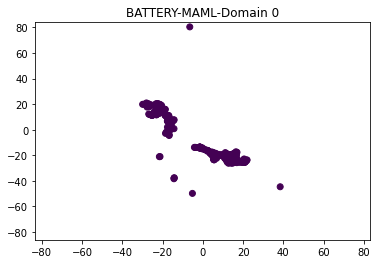

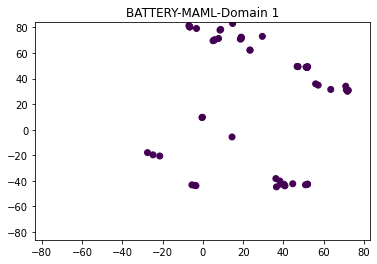

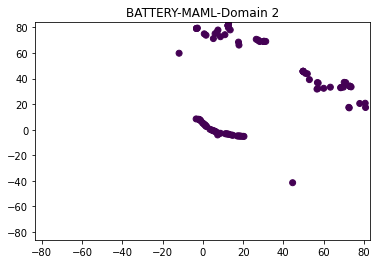

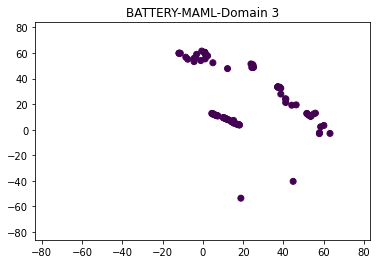

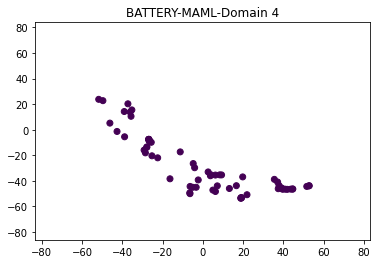

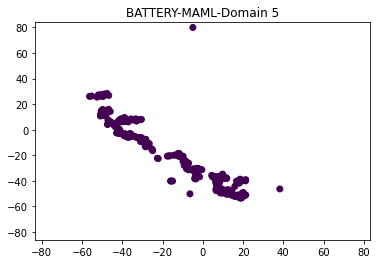

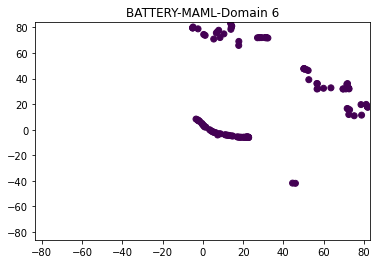

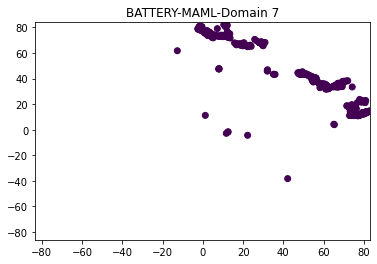

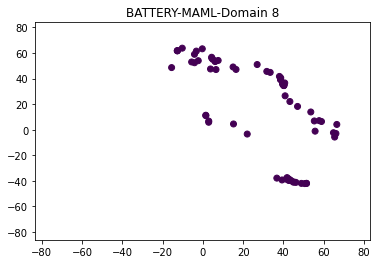

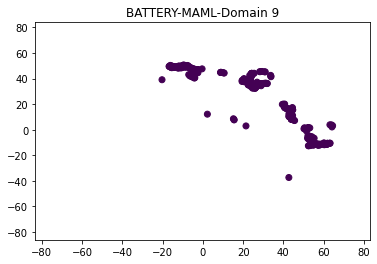

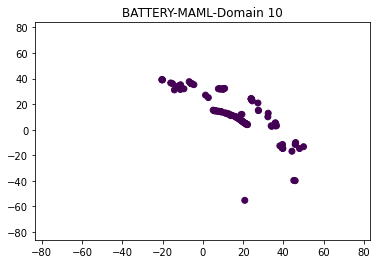

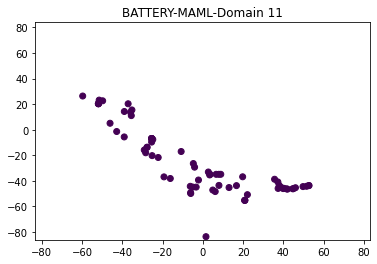

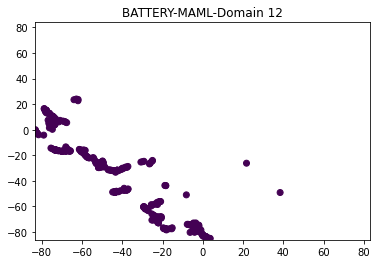

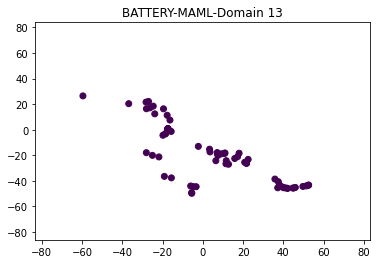

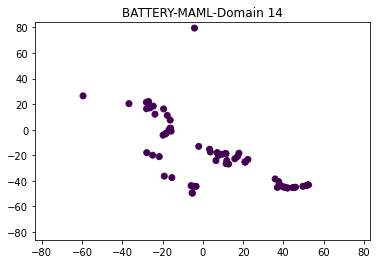

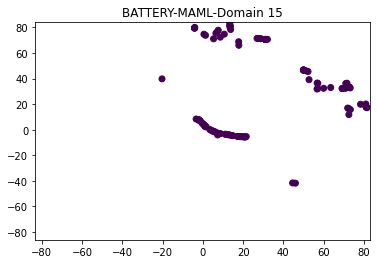

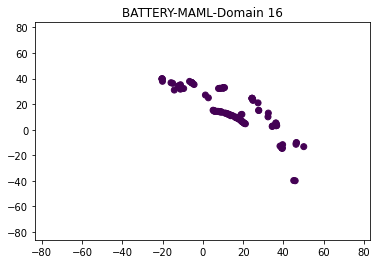

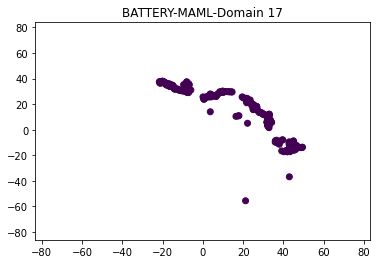

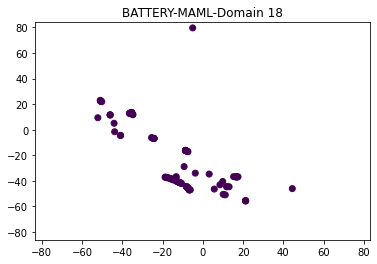

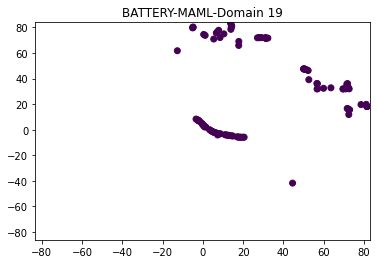

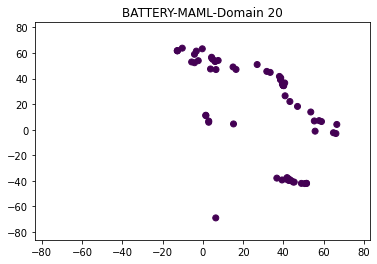

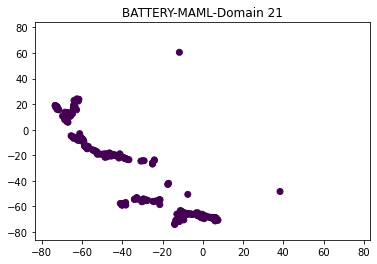

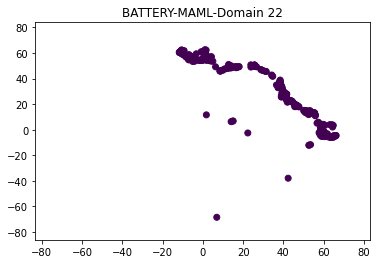

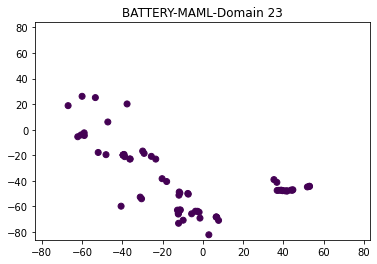

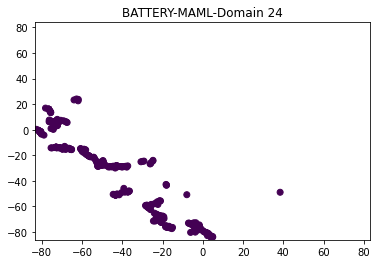

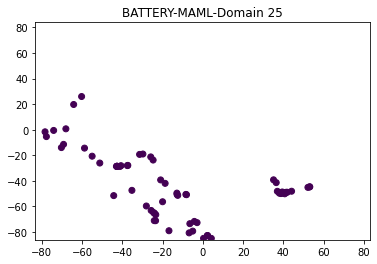

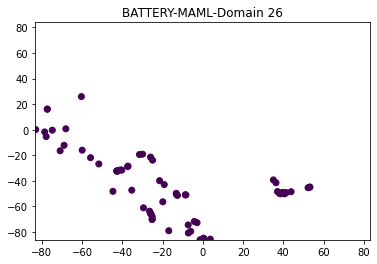

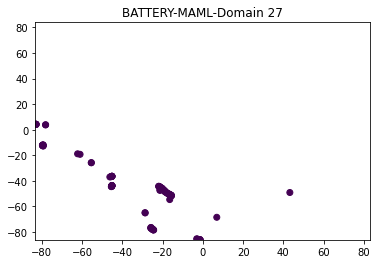

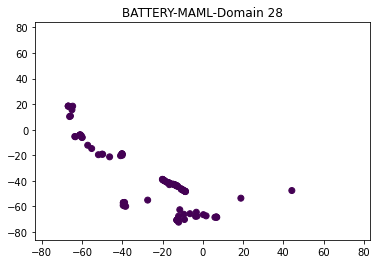

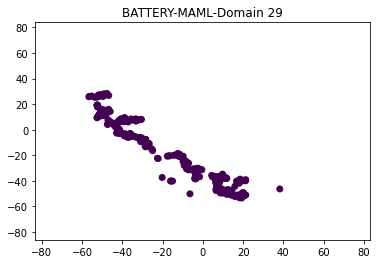

In [88]:
xlim = (np.min(X_embedded[:,0]), np.max(X_embedded[:,0]))
ylim = (np.min(X_embedded[:,1]), np.max(X_embedded[:,1]))

for idx in range(max(idx_list)+1):
    
    fig = plt.figure()
    idx_select = np.where(np.array(idx_list[:-1])==idx)[0]
    plt.scatter(X_embedded[idx_select,0],  X_embedded[idx_select,1], c=np.array(idx_list)[idx_select])
    plt.title(dataset_name+"-MAML-Domain "+str(idx))
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.savefig("../../Results/figures/"+dataset_name+"-MMAML-ENCODING-DOMAIN"+str(idx)+".jpg")

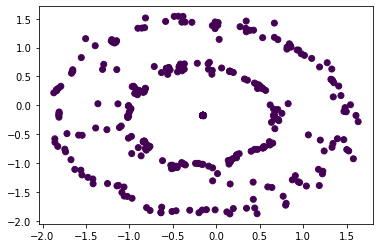

In [22]:
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, len(idx_list)))
plt.scatter(X_embedded[:,0],  X_embedded[:,1], c=idx_list)


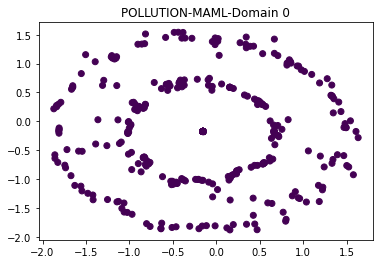

In [23]:
for idx in range(max(idx_list)+1):
    
    fig = plt.figure()
    idx_select = np.where(np.array(idx_list)==idx)[0]
    plt.scatter(X_embedded[idx_select,0],  X_embedded[idx_select,1], c=np.array(idx_list)[idx_select])
    plt.title(dataset_name+"-MAML-Domain "+str(idx))
    #plt.savefig("../../Results/figures/"+dataset_name+"-MAML-Domain "+str(idx)+".jpg")

In [26]:

def fig2data ( fig ):
    """
    @brief Convert a Matplotlib figure to a 4D numpy array with RGBA channels and return it
    @param fig a matplotlib figure
    @return a numpy 3D array of RGBA values
    """
    # draw the renderer
    fig.canvas.draw ( )
 
    # Get the RGBA buffer from the figure
    w,h = fig.canvas.get_width_height()
    buf = numpy.fromstring ( fig.canvas.tostring_argb(), dtype=numpy.uint8 )
    buf.shape = ( w, h,4 )
 
    # canvas.tostring_argb give pixmap in ARGB mode. Roll the ALPHA channel to have it in RGBA mode
    buf = numpy.roll ( buf, 3, axis = 2 )
    return buf

def fig2img ( fig ):
    """
    @brief Convert a Matplotlib figure to a PIL Image in RGBA format and return it
    @param fig a matplotlib figure
    @return a Python Imaging Library ( PIL ) image
    """
    # put the figure pixmap into a numpy array
    buf = fig2data ( fig )
    w, h, d = buf.shape
    return Image.frombytes( "RGBA", ( w ,h ), buf.tostring( ) )

In [27]:
plt.show()

In [28]:
import numpy
from PIL import Image


C:\Users\Sebastian\Anaconda3\envs\pytorch12\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':
C:\Users\Sebastian\Anaconda3\envs\pytorch12\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


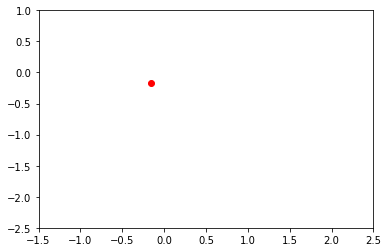

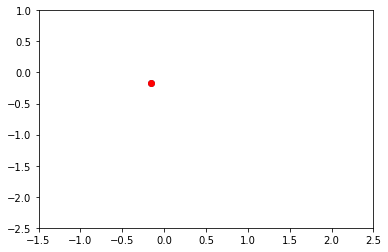

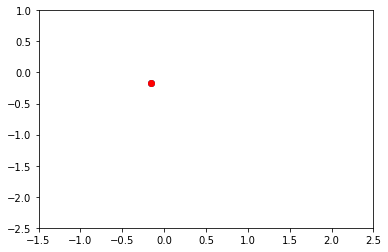

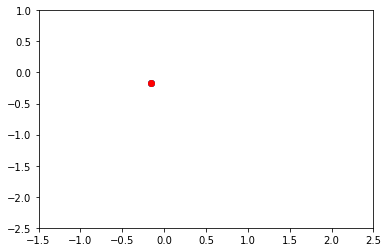

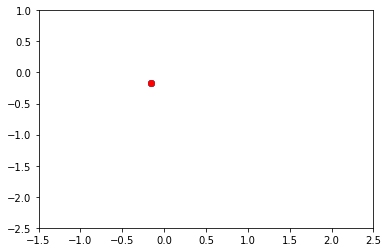

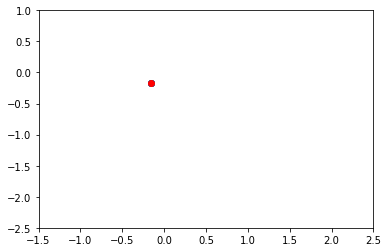

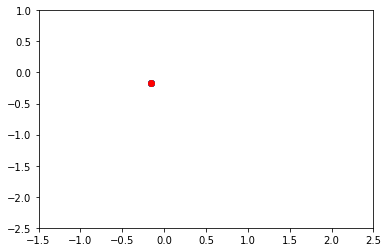

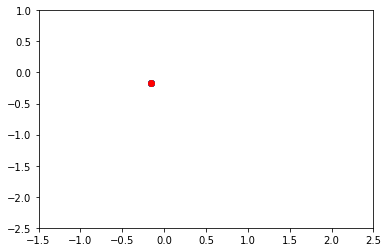

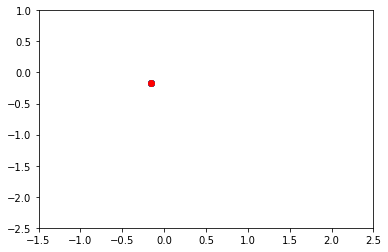

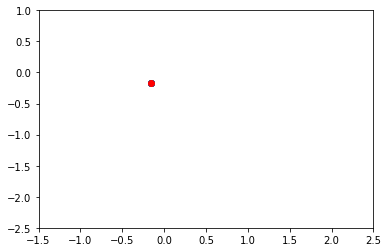

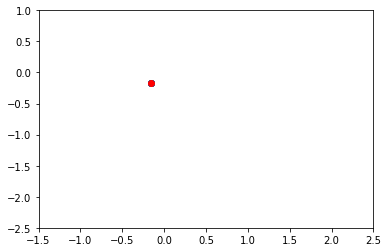

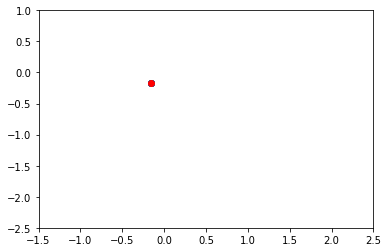

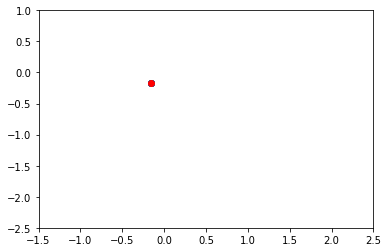

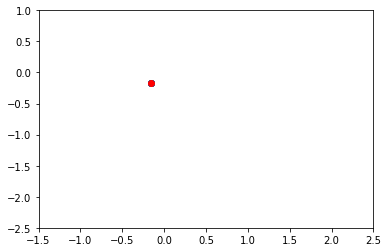

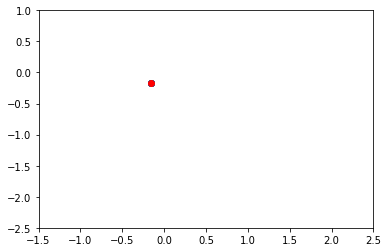

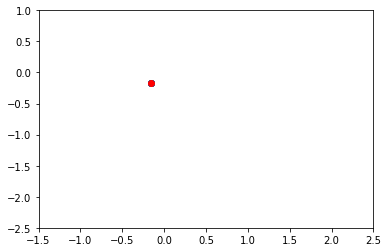

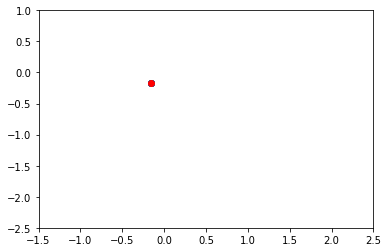

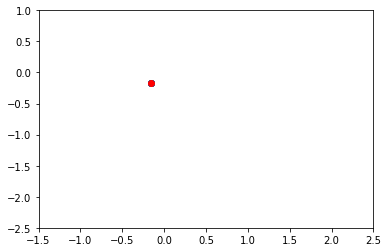

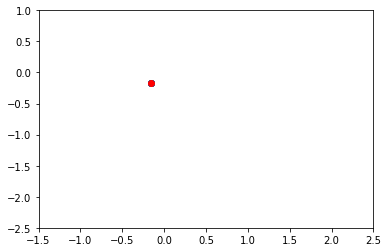

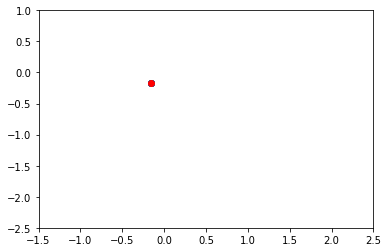

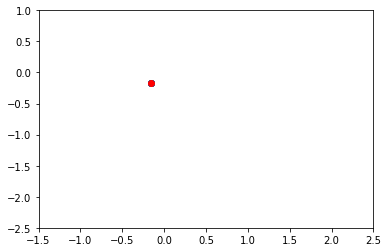

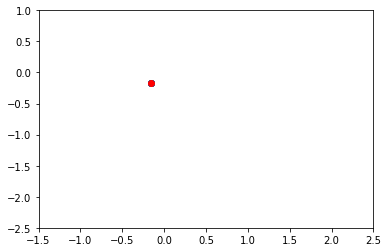

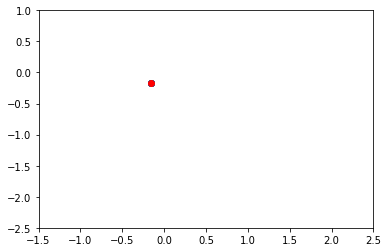

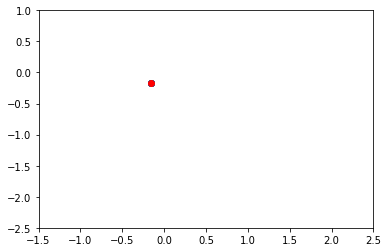

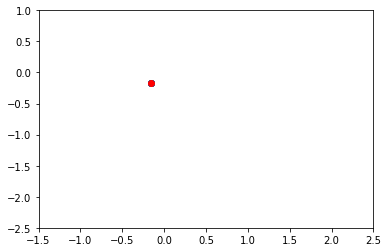

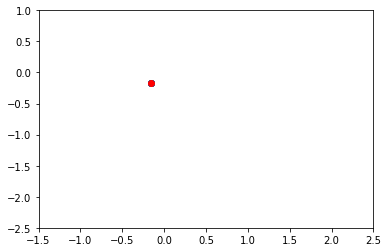

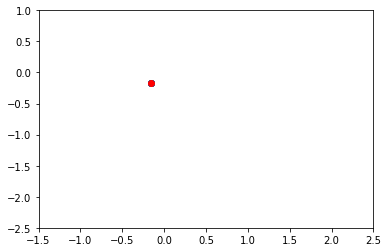

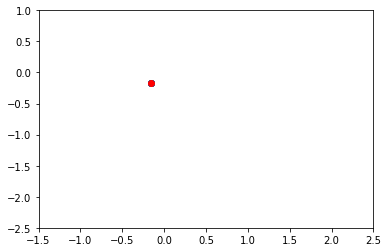

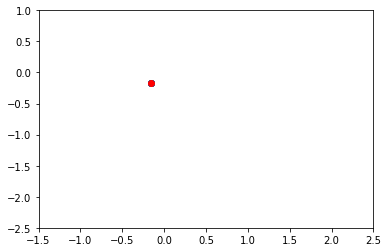

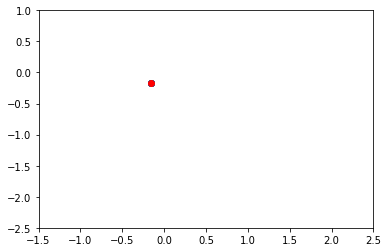

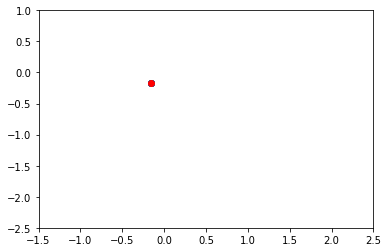

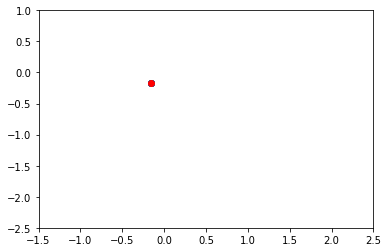

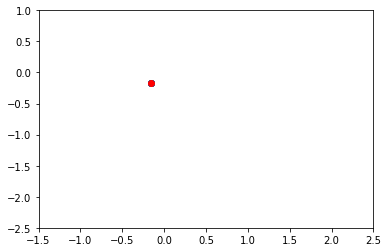

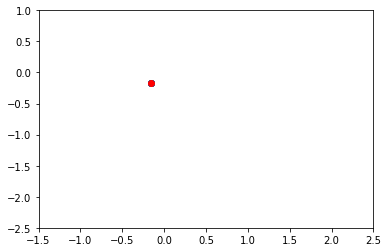

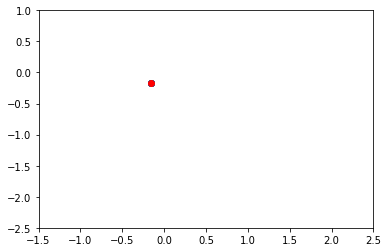

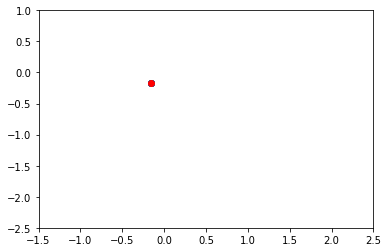

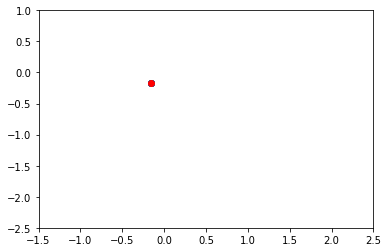

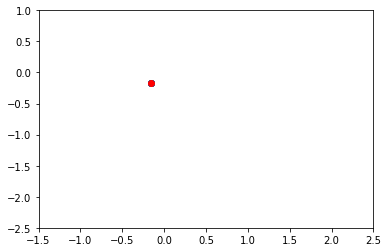

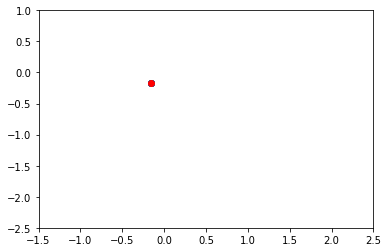

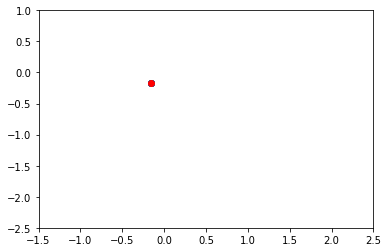

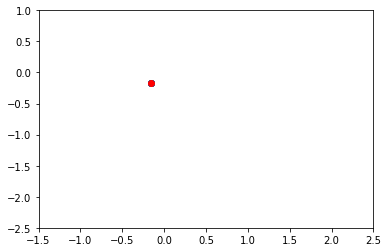

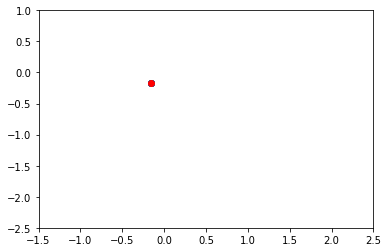

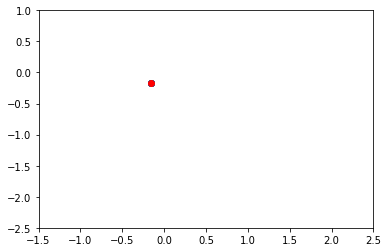

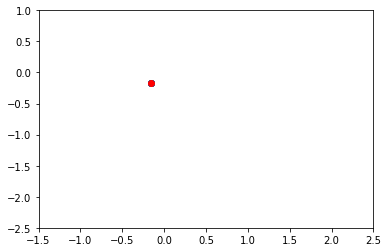

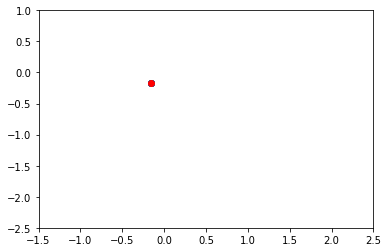

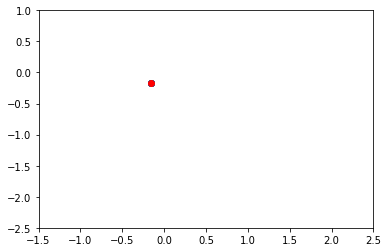

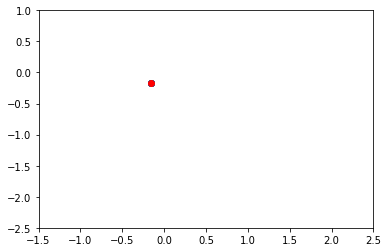

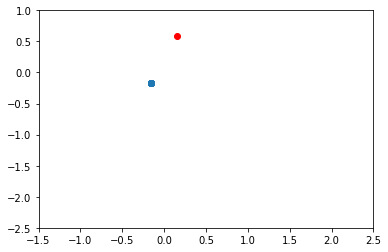

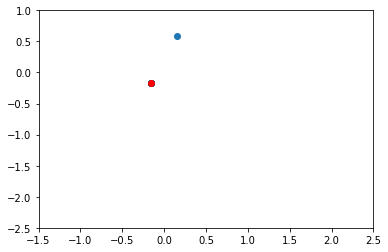

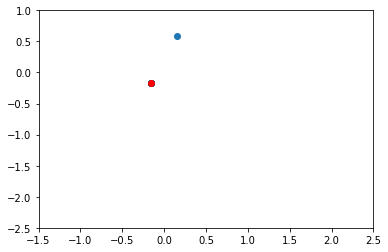

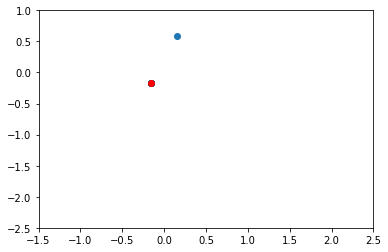

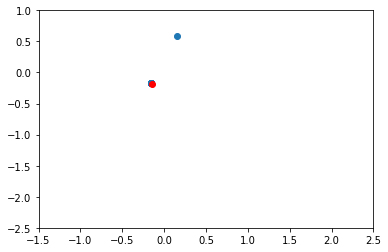

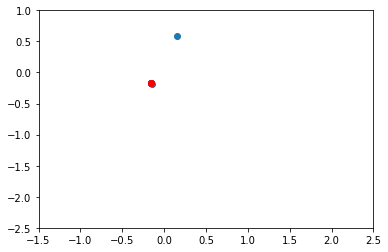

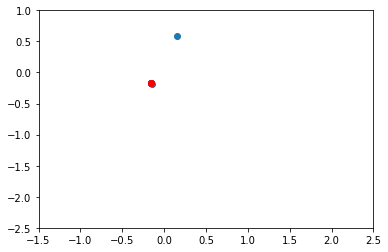

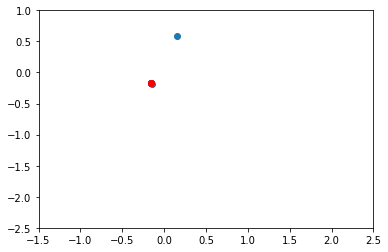

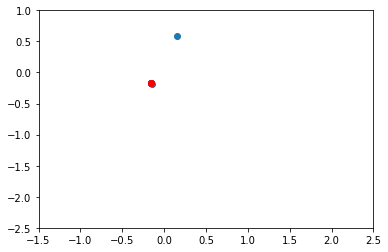

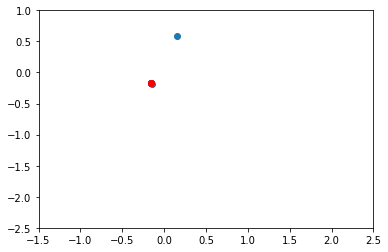

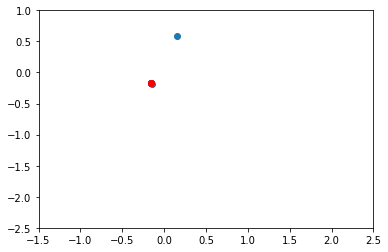

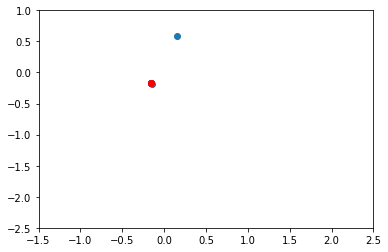

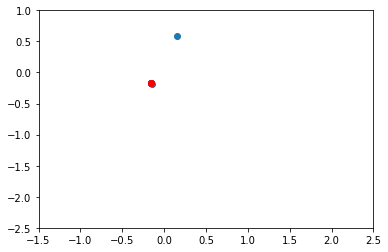

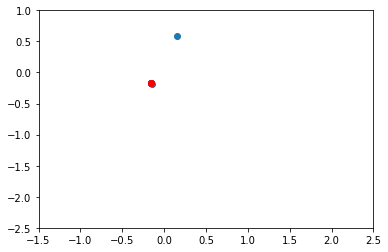

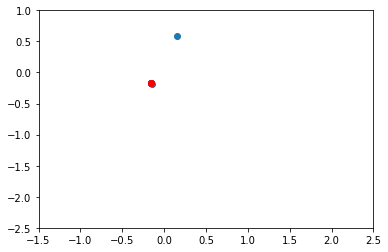

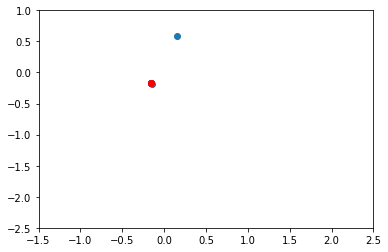

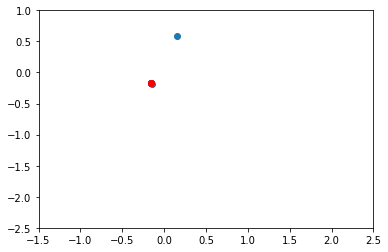

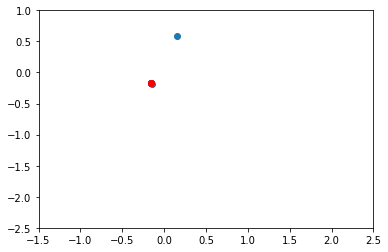

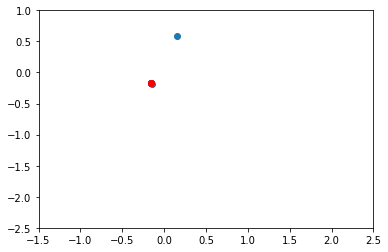

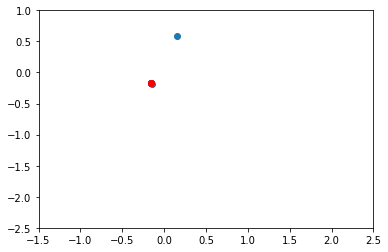

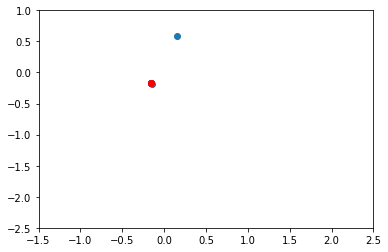

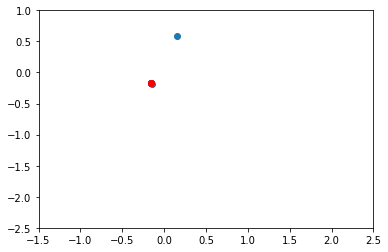

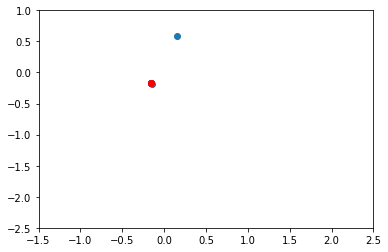

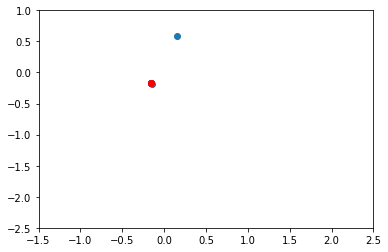

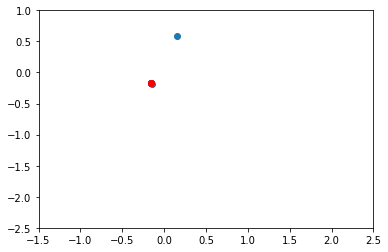

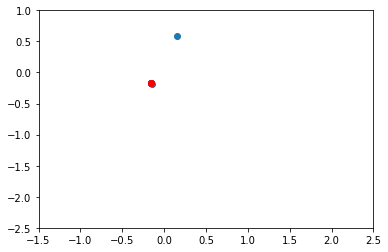

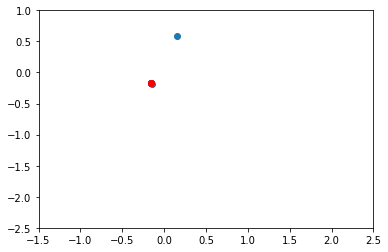

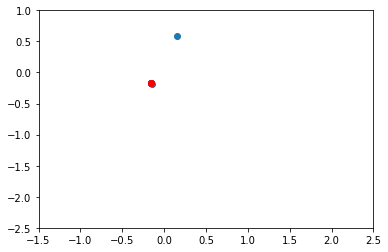

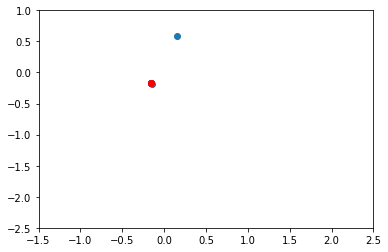

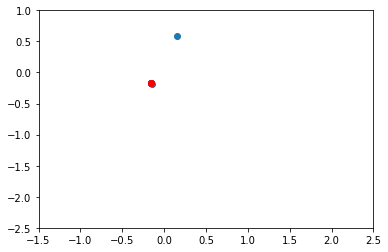

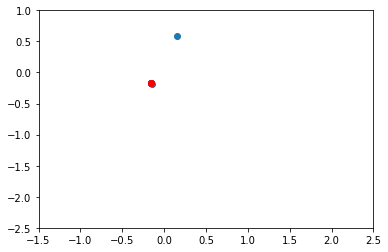

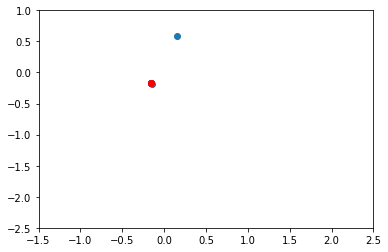

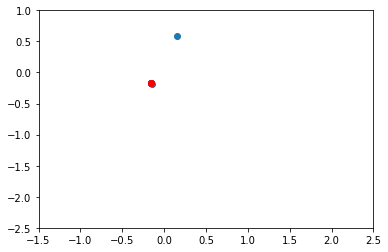

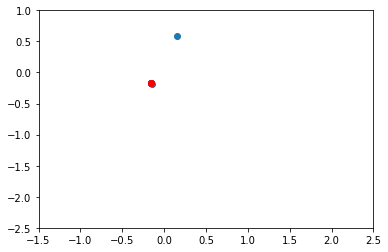

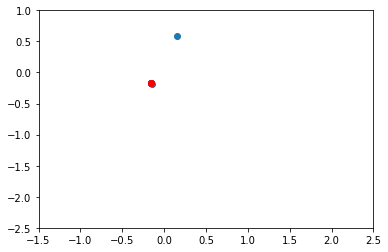

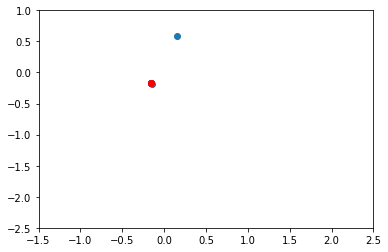

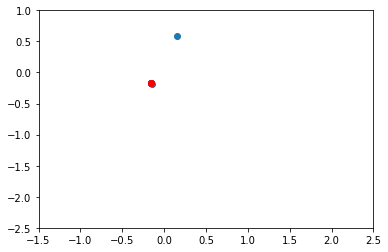

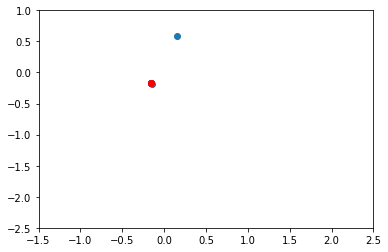

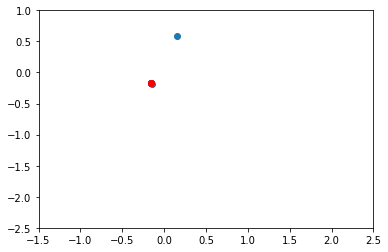

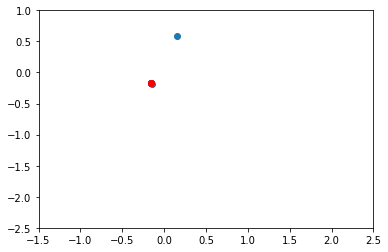

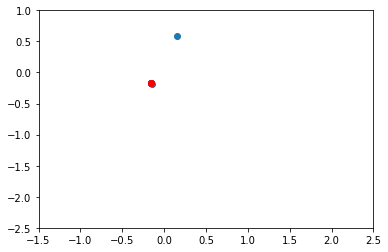

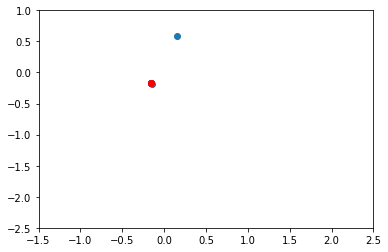

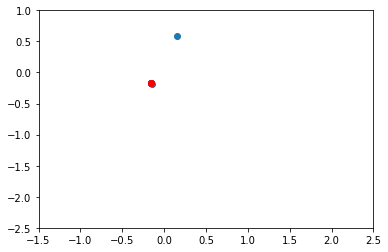

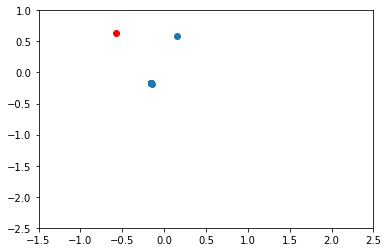

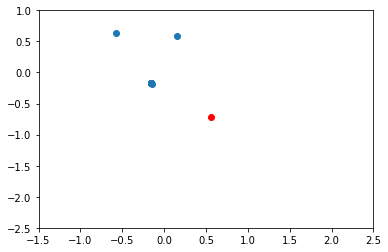

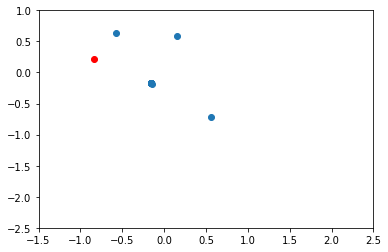

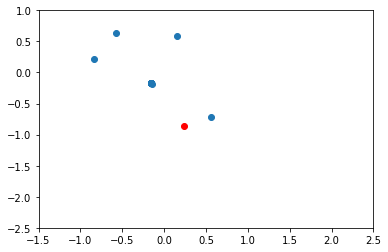

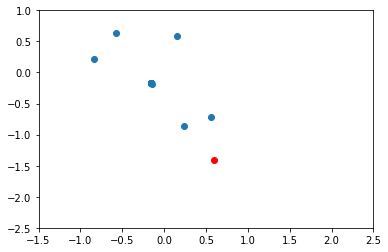

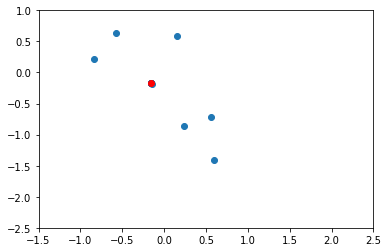

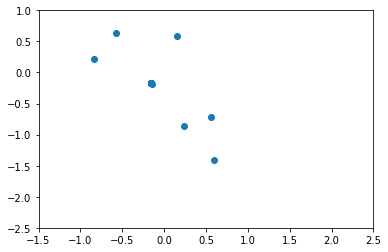

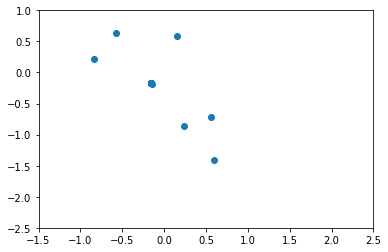

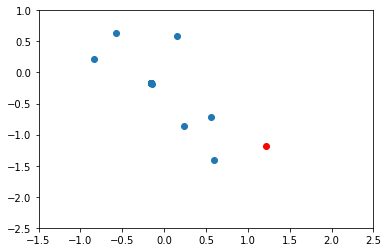

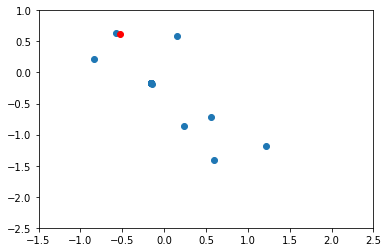

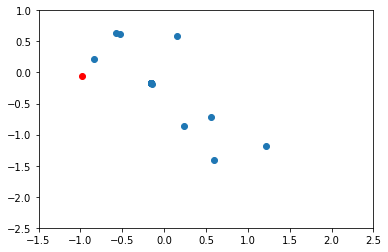

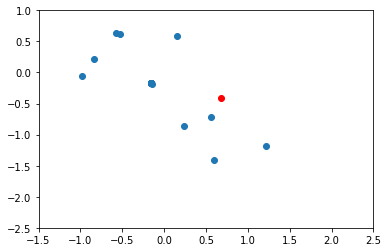

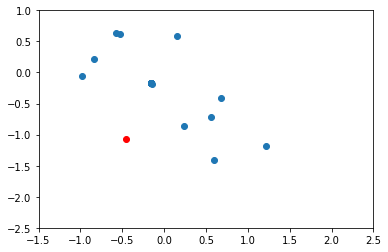

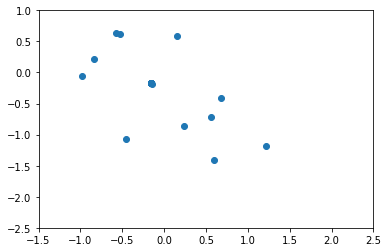

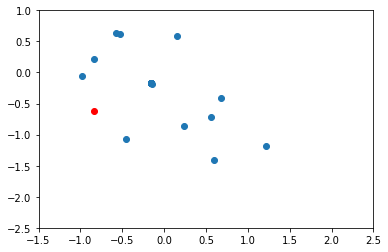

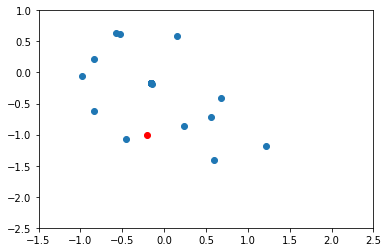

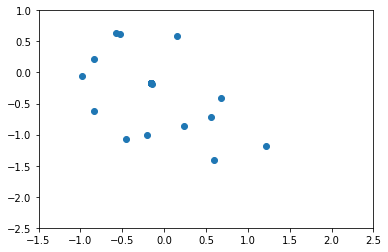

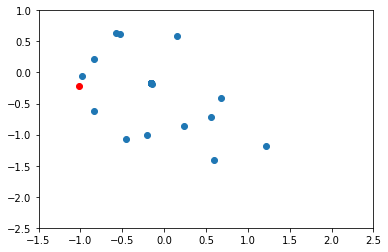

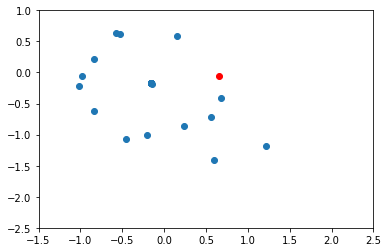

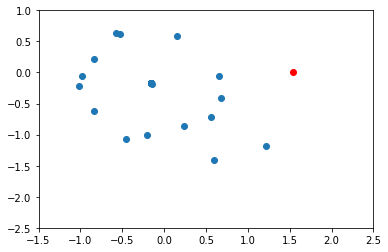

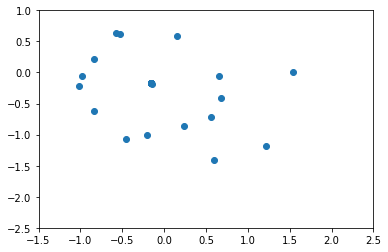

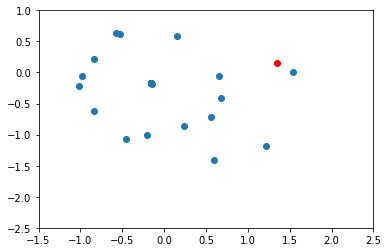

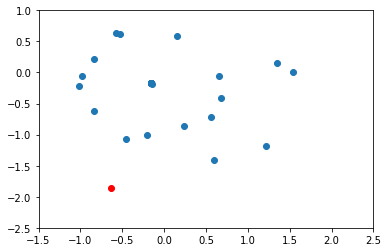

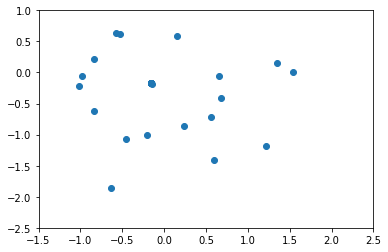

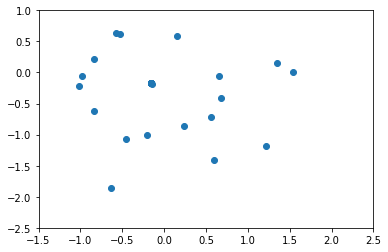

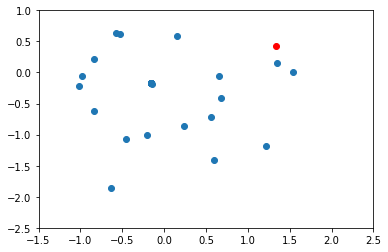

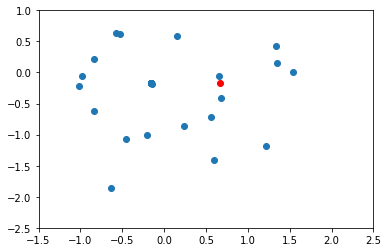

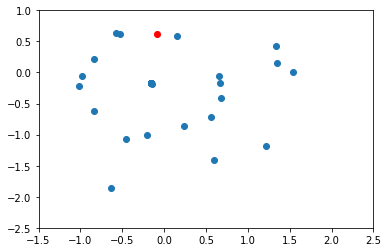

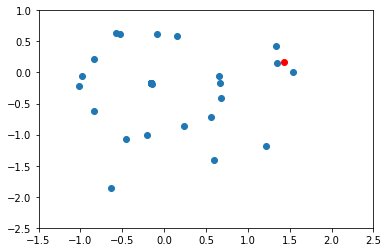

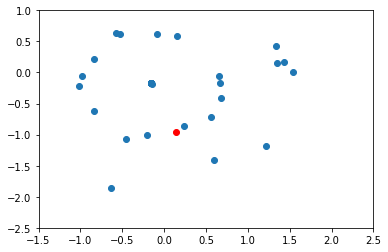

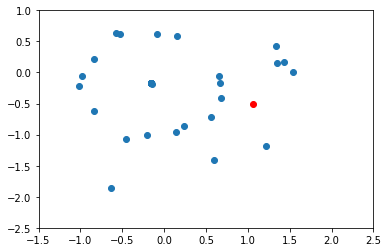

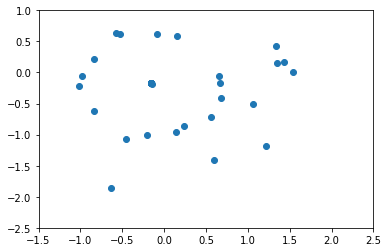

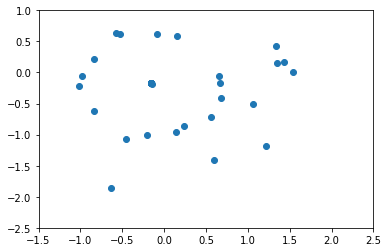

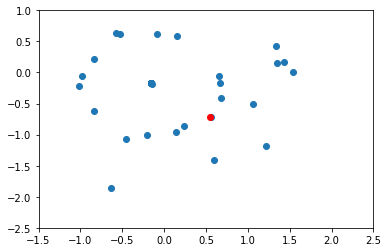

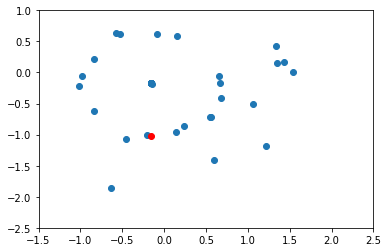

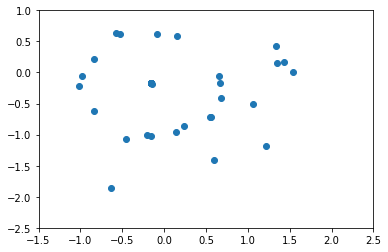

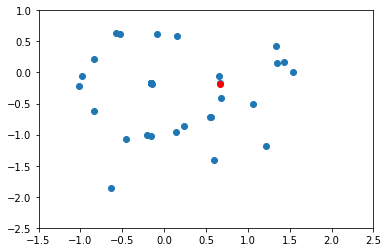

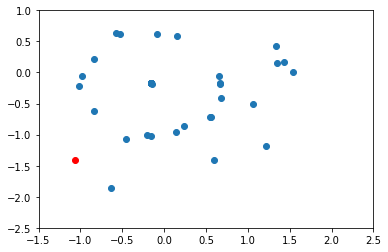

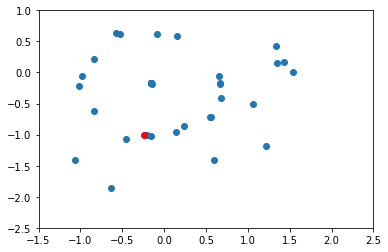

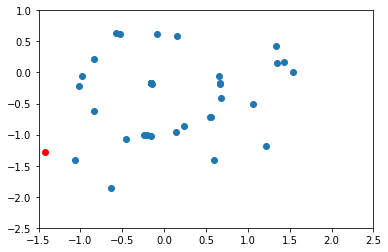

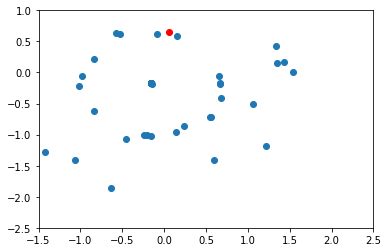

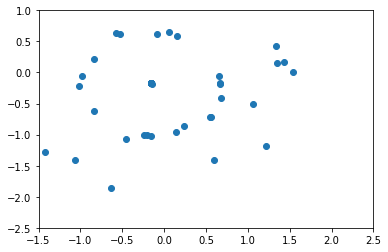

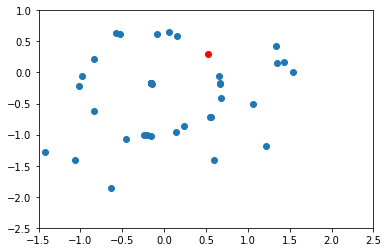

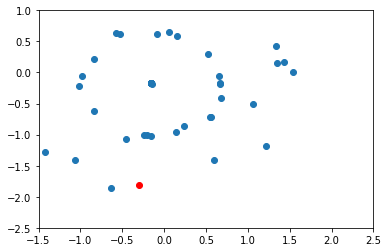

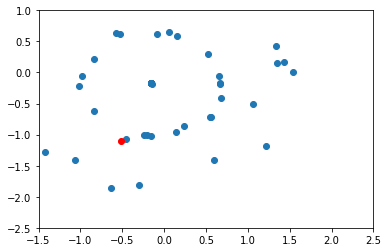

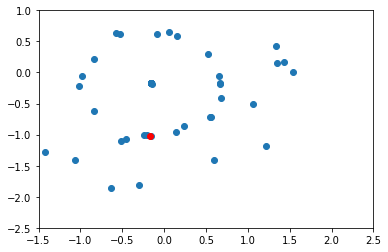

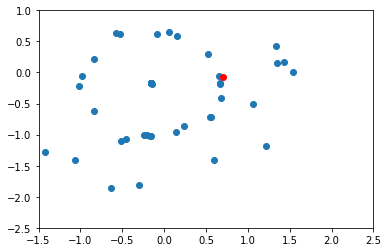

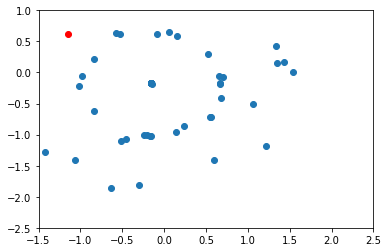

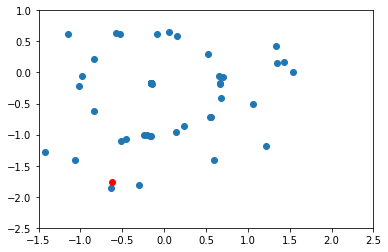

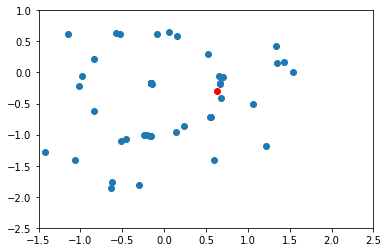

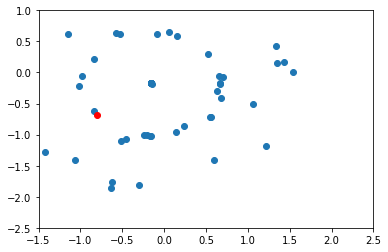

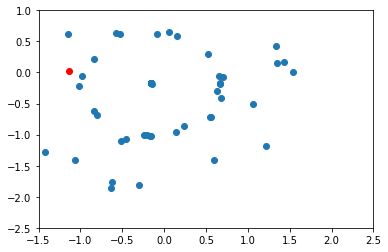

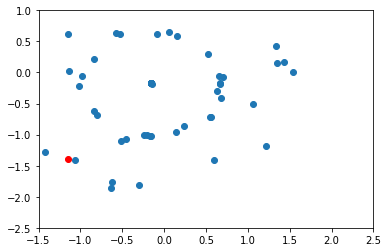

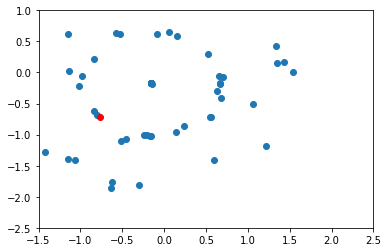

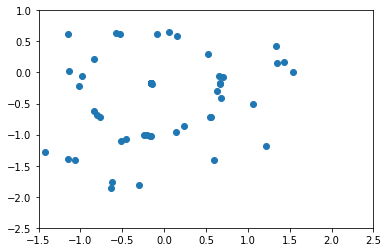

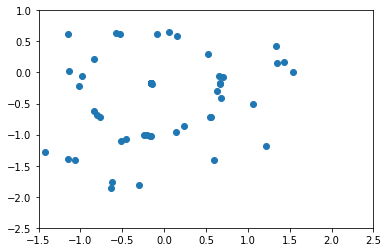

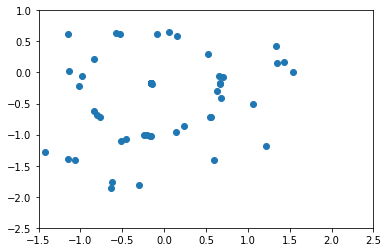

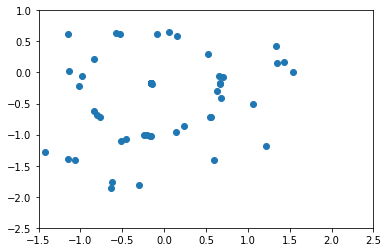

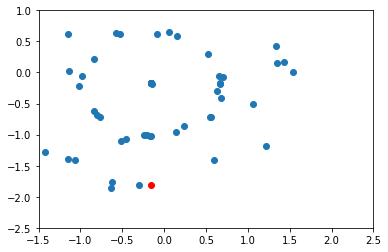

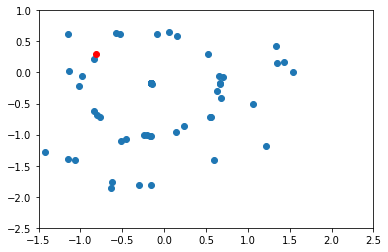

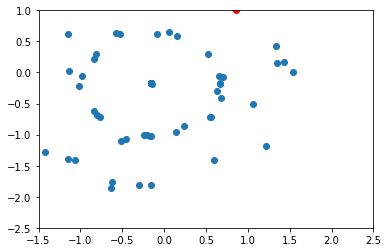

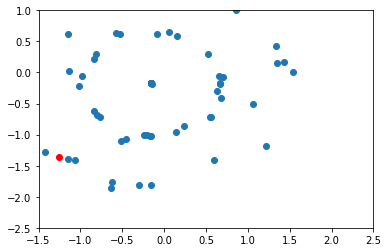

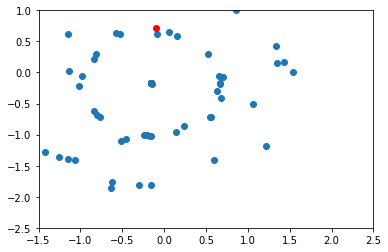

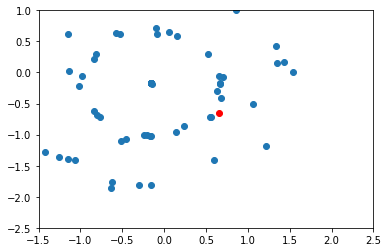

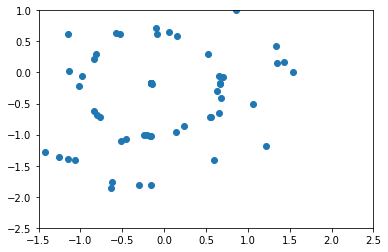

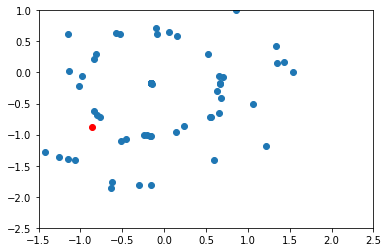

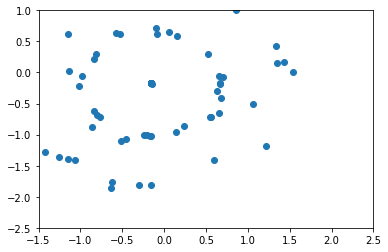

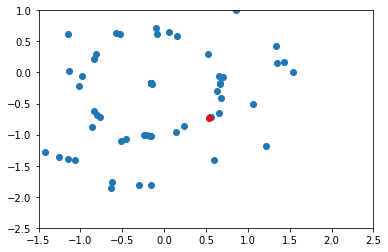

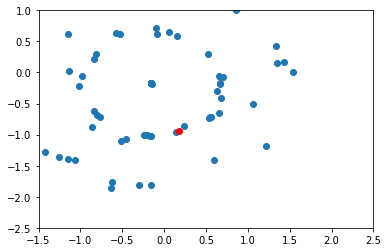

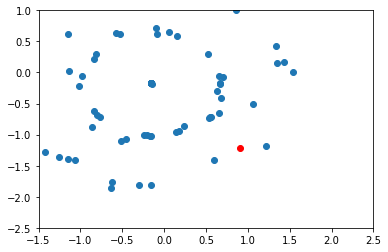

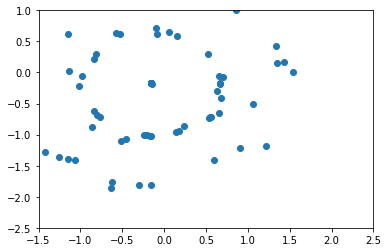

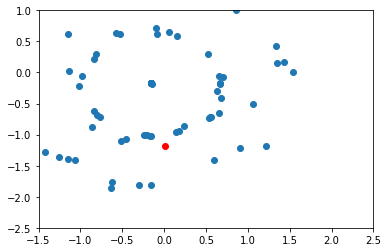

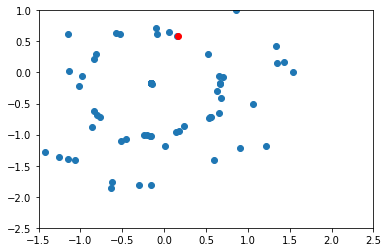

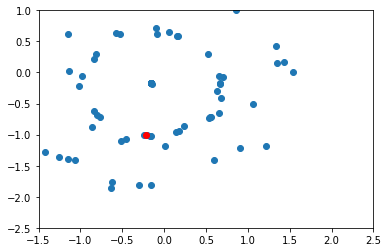

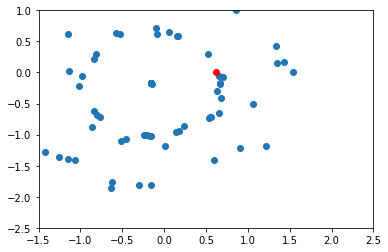

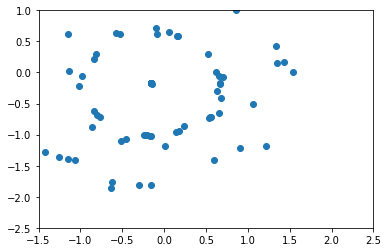

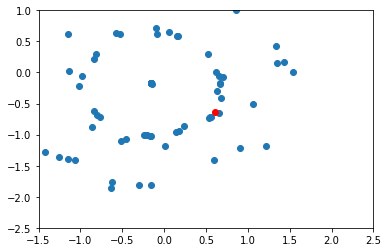

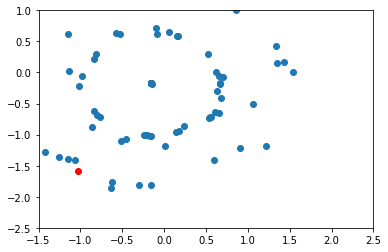

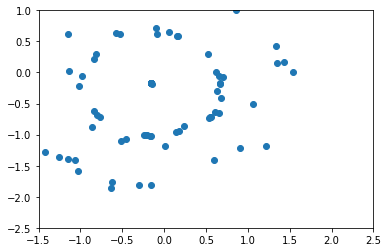

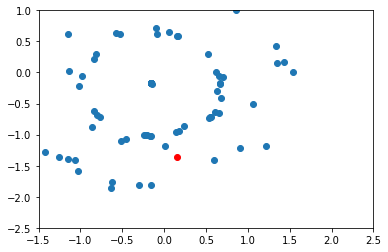

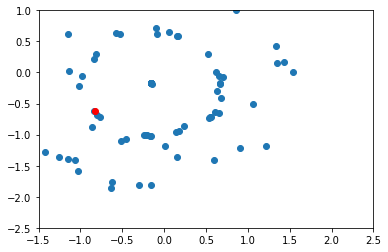

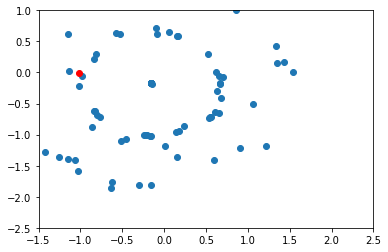

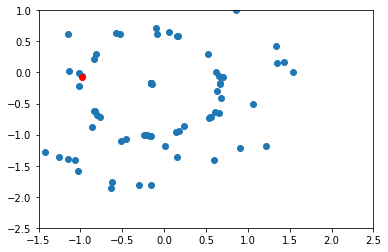

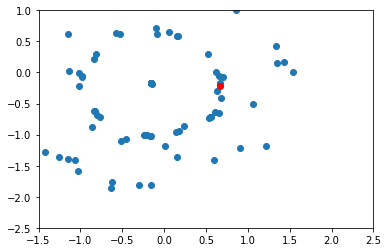

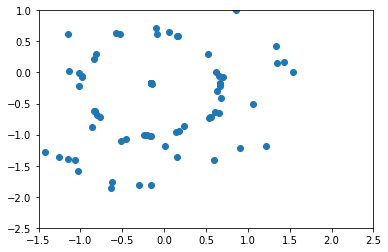

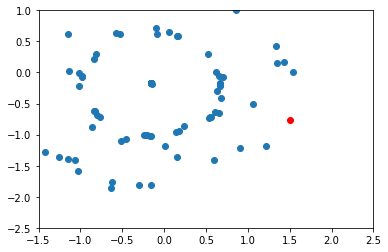

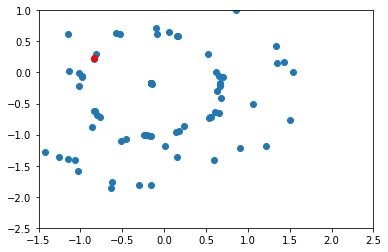

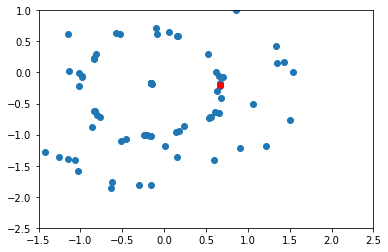

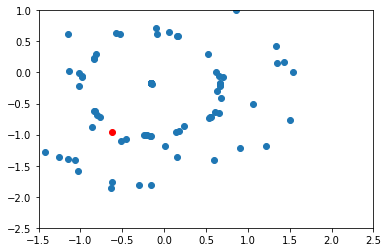

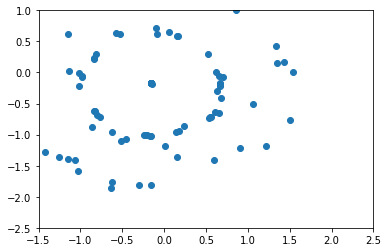

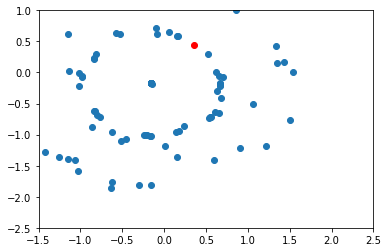

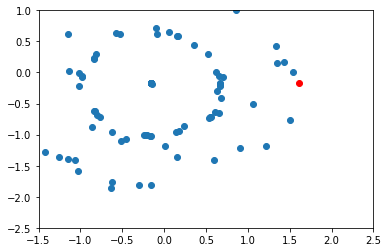

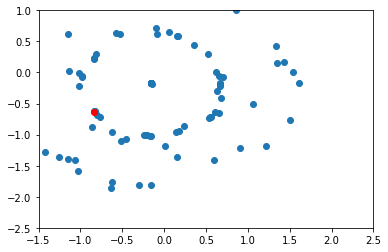

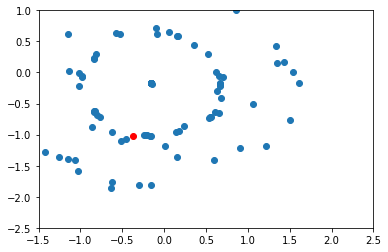

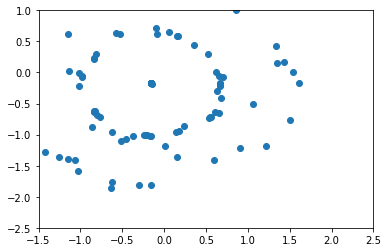

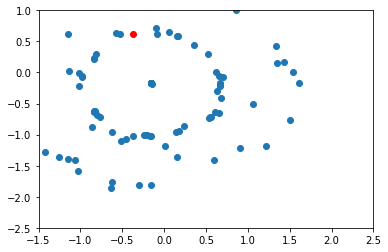

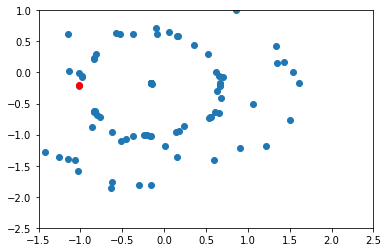

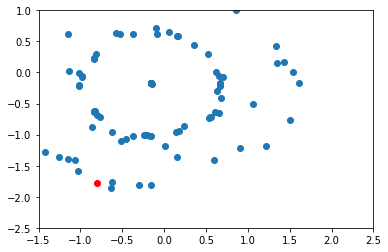

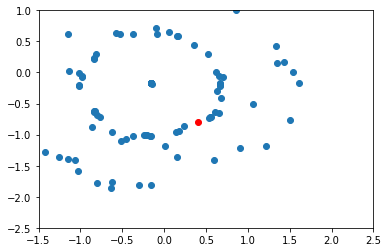

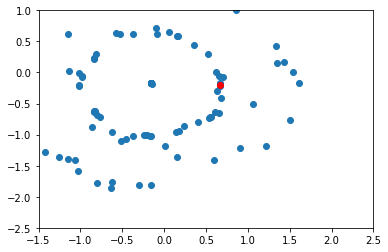

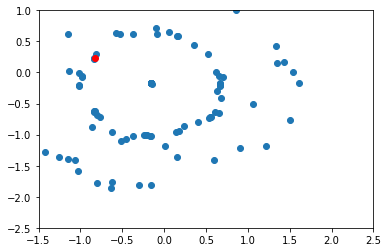

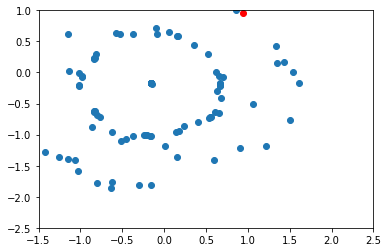

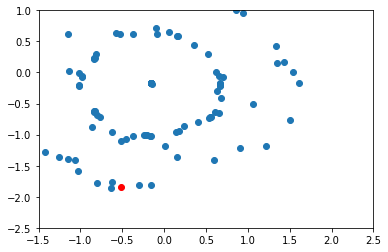

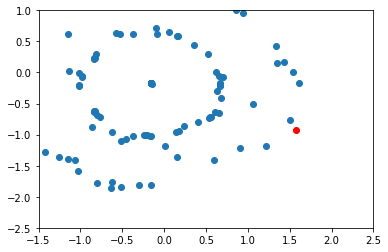

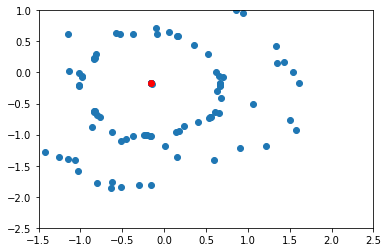

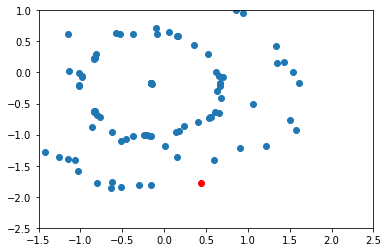

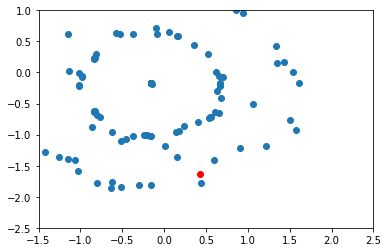

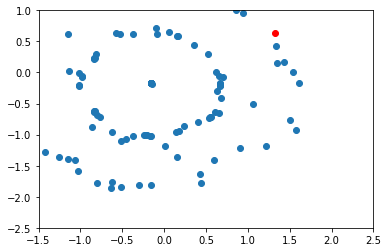

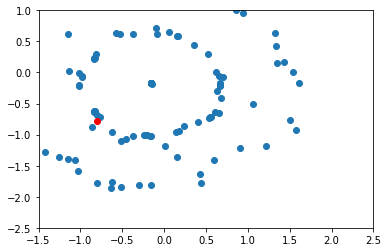

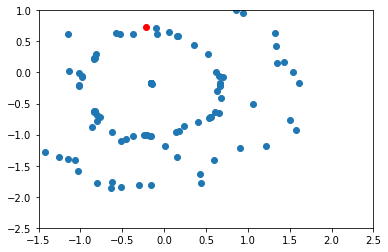

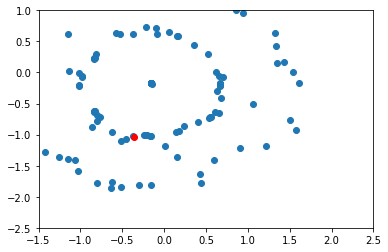

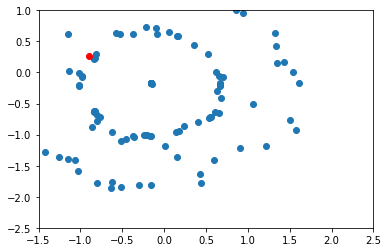

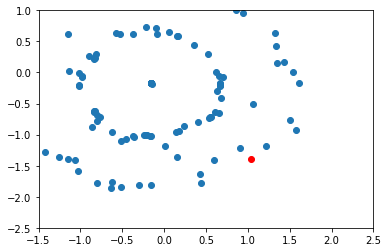

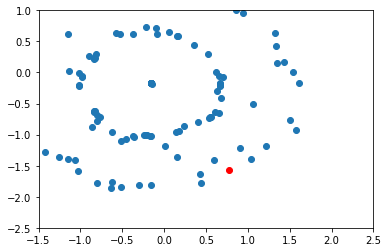

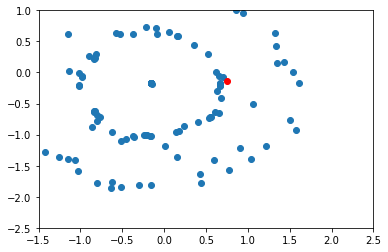

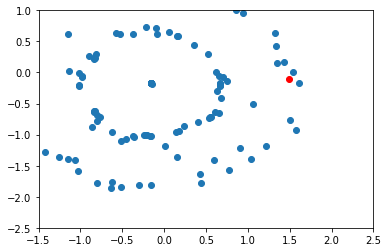

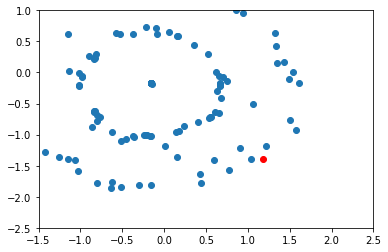

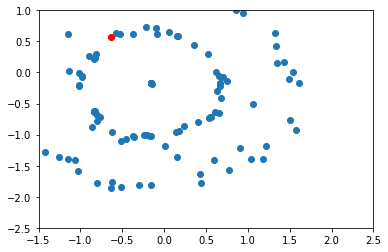

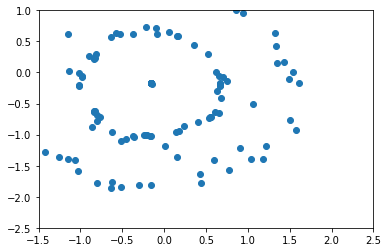

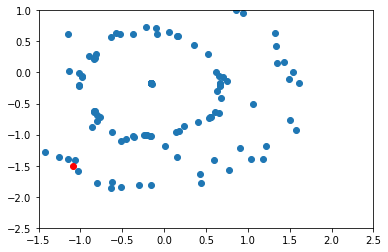

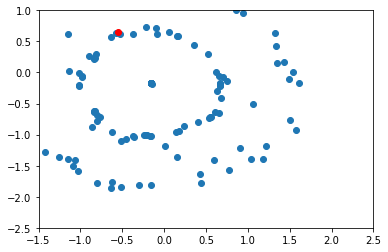

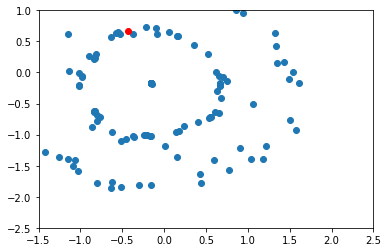

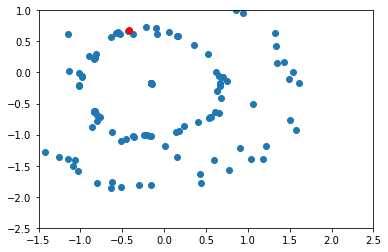

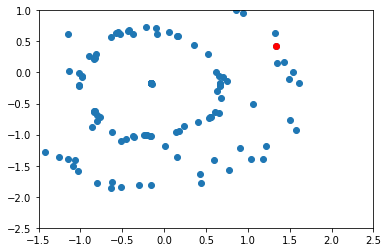

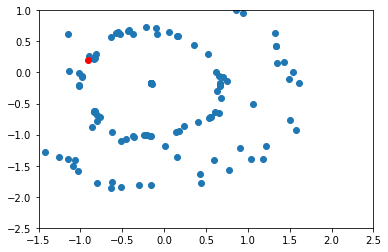

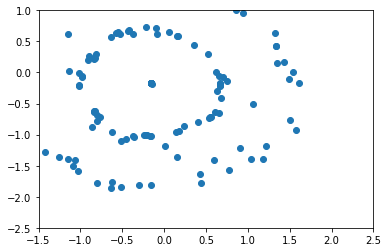

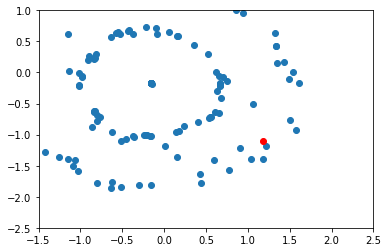

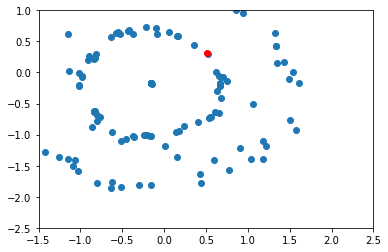

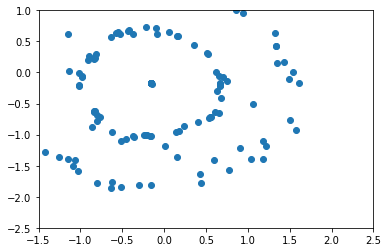

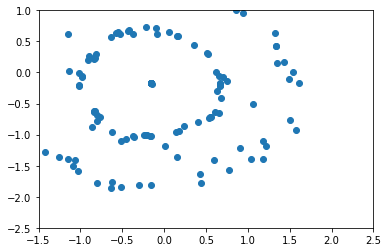

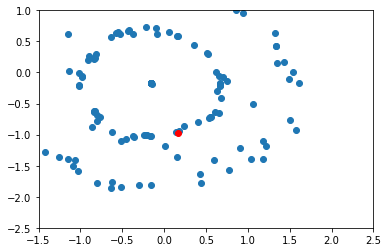

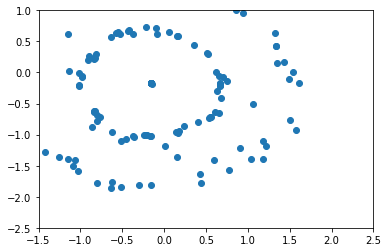

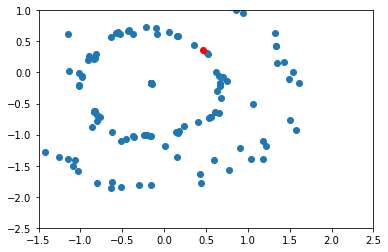

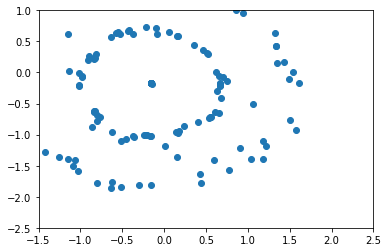

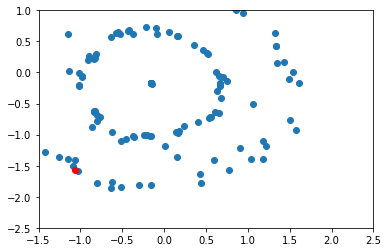

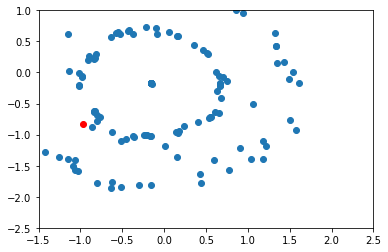

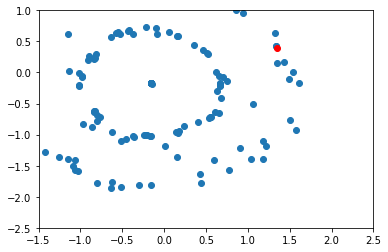

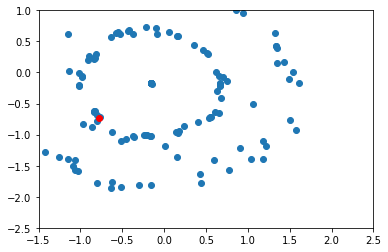

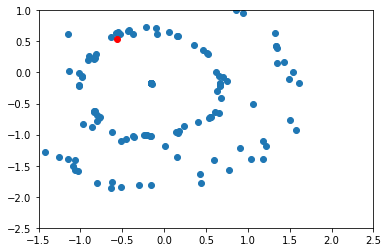

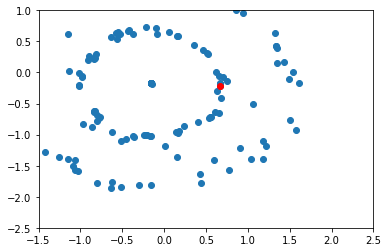

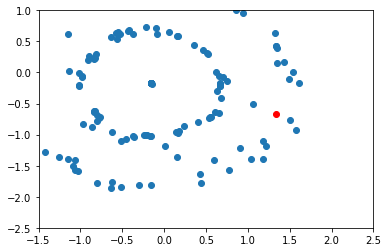

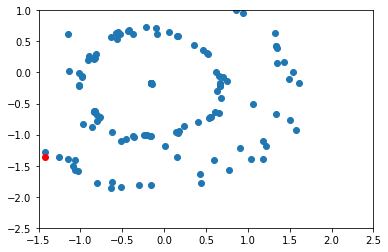

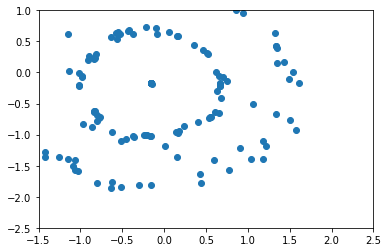

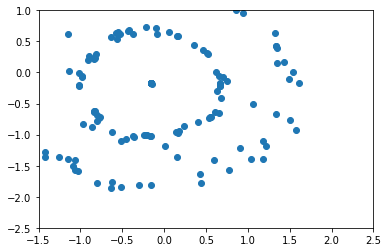

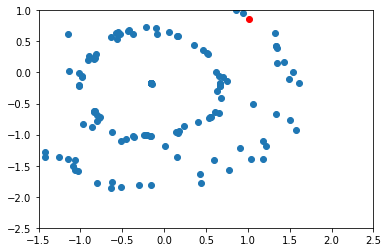

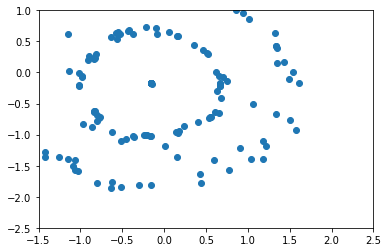

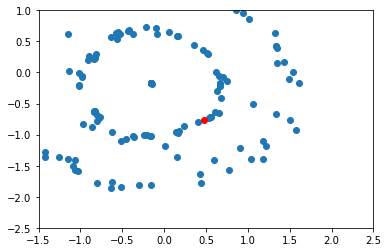

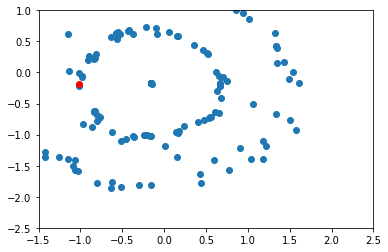

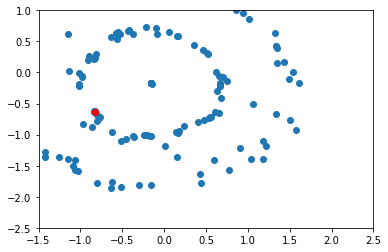

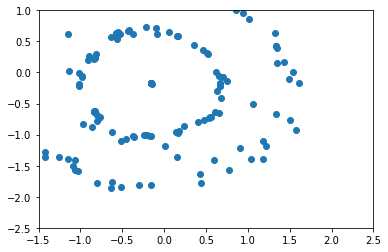

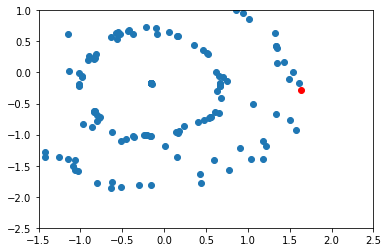

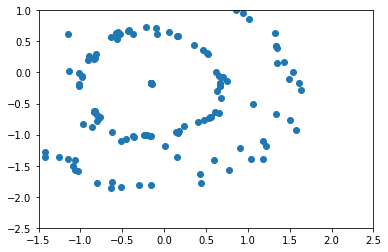

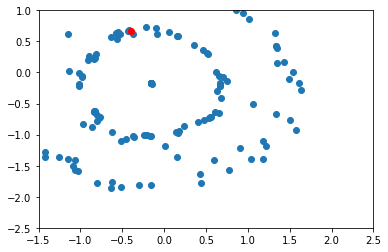

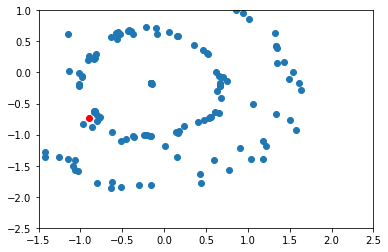

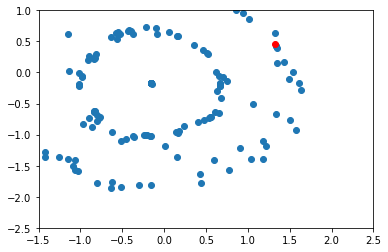

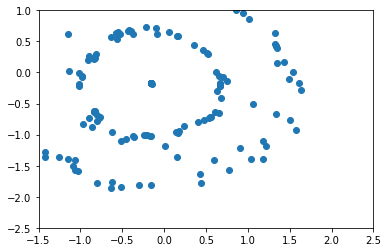

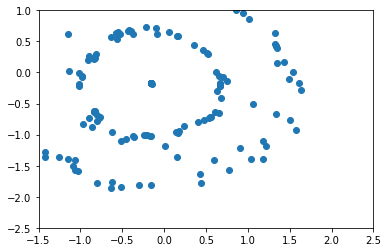

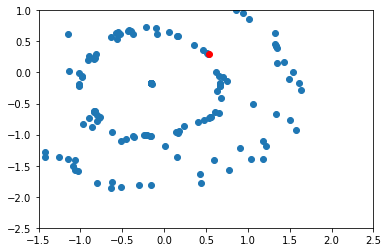

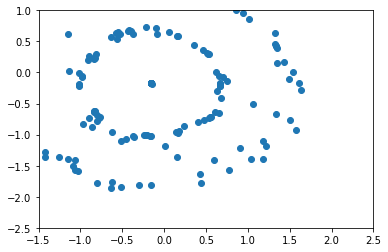

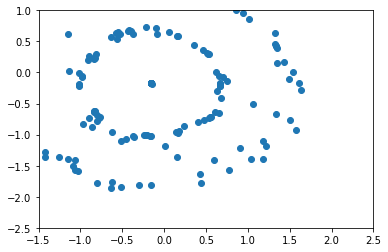

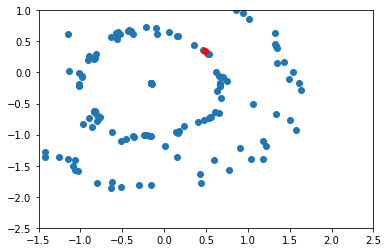

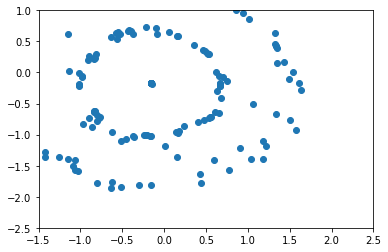

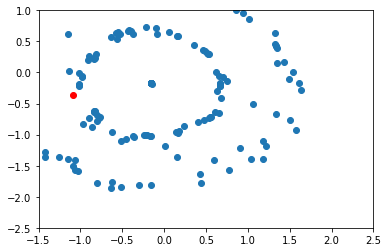

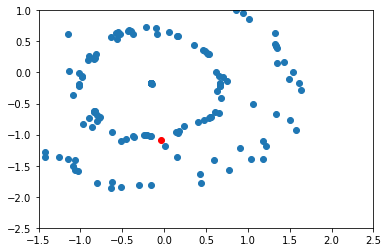

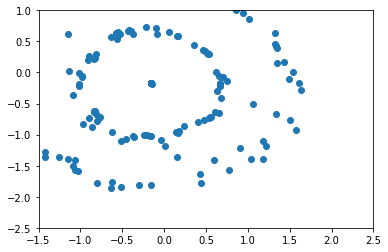

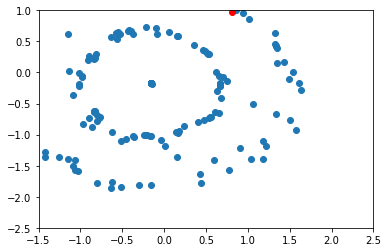

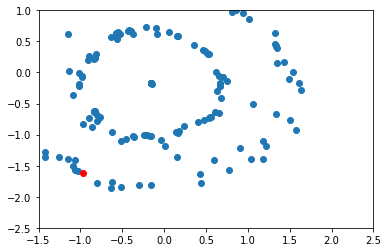

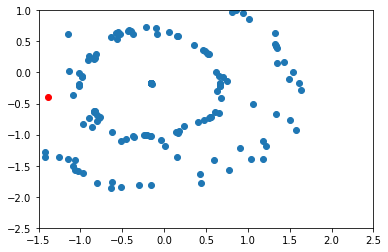

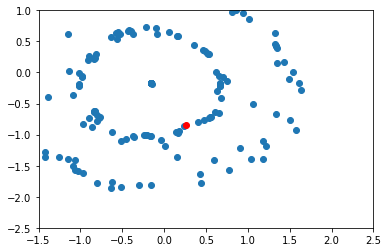

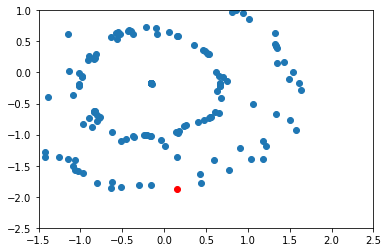

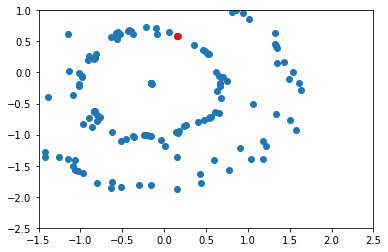

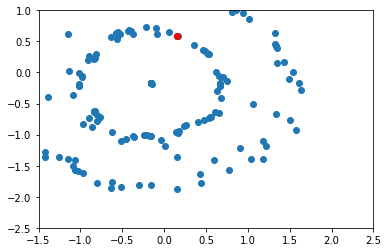

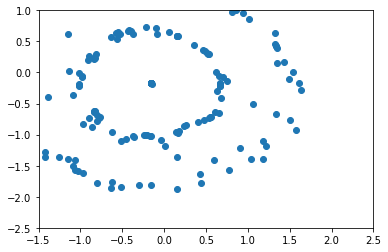

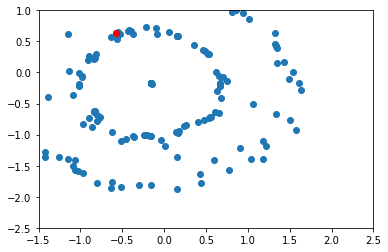

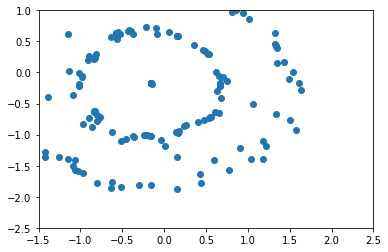

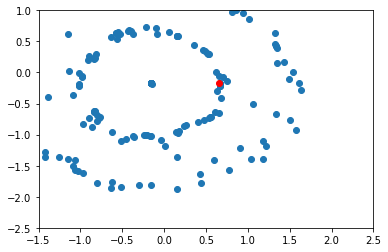

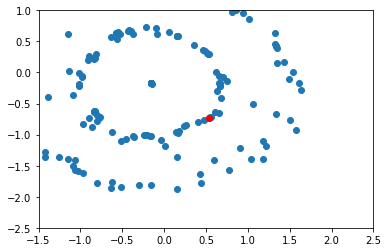

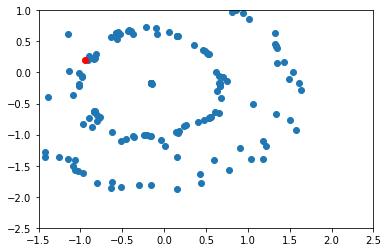

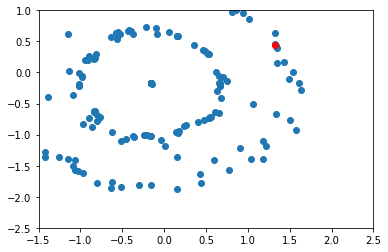

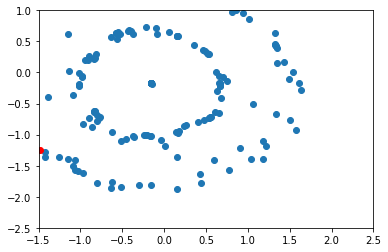

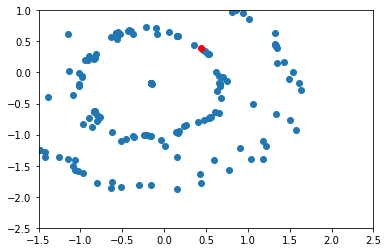

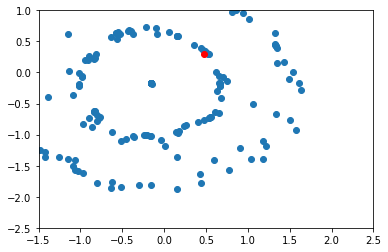

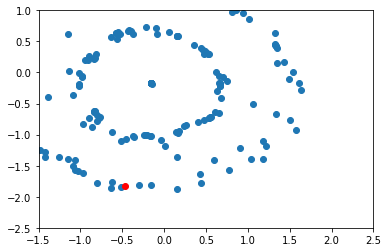

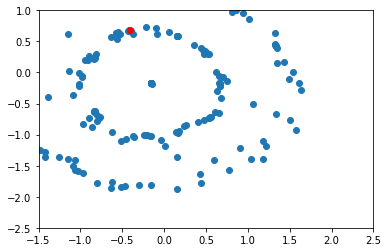

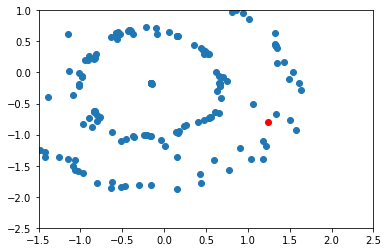

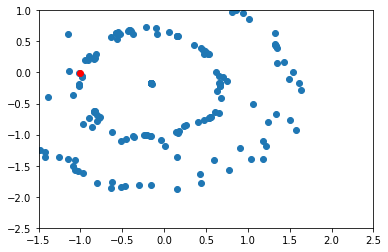

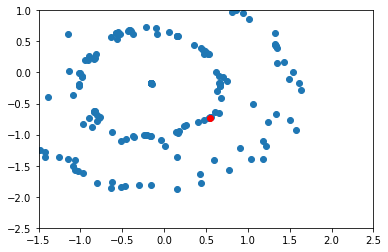

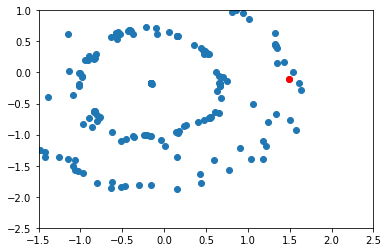

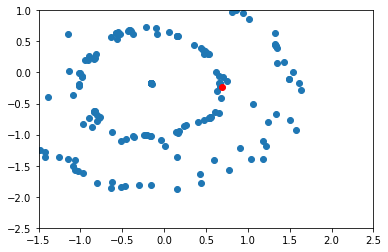

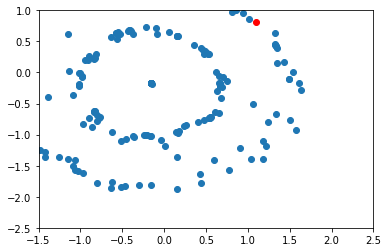

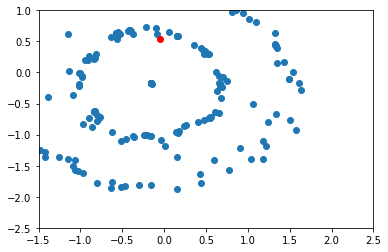

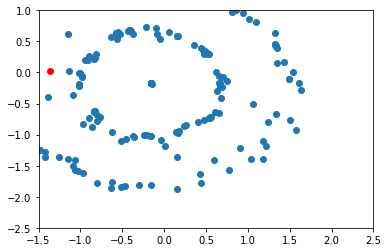

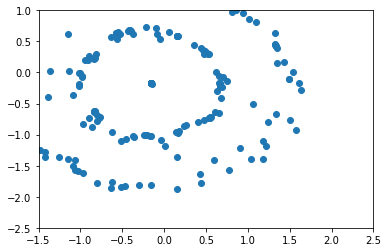

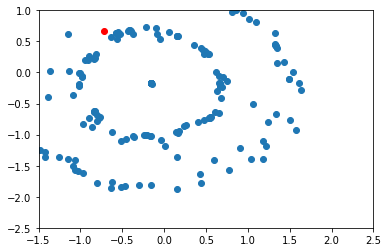

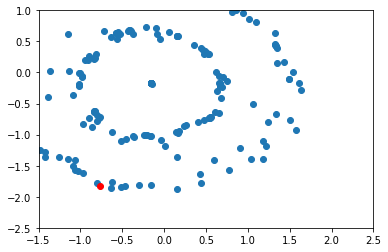

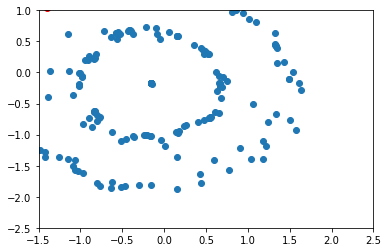

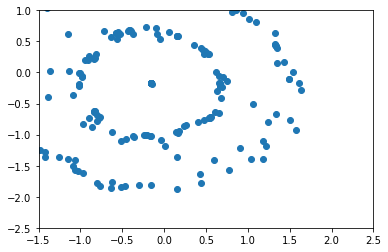

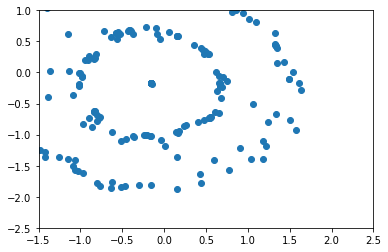

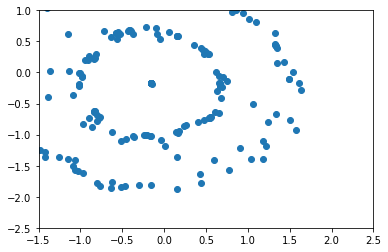

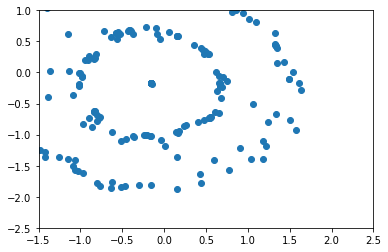

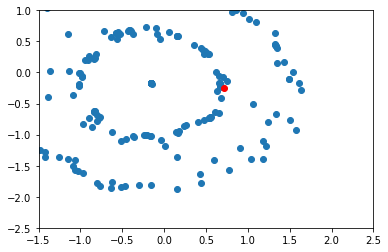

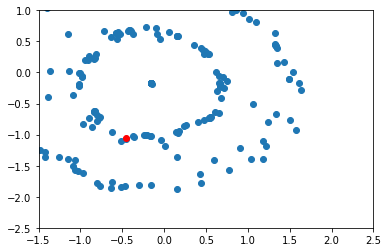

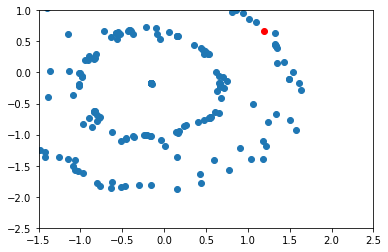

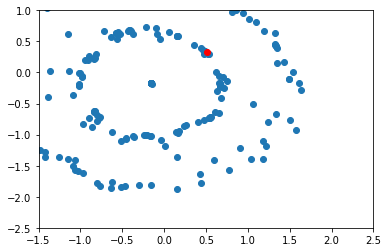

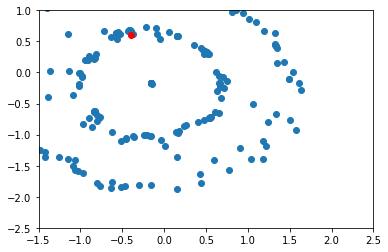

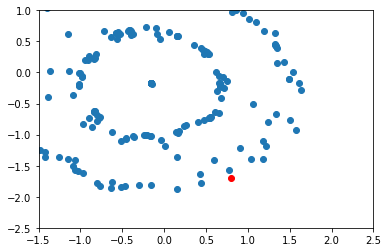

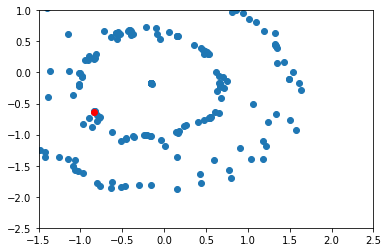

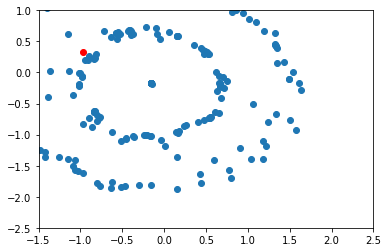

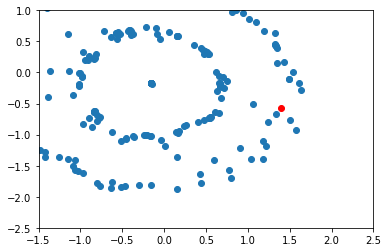

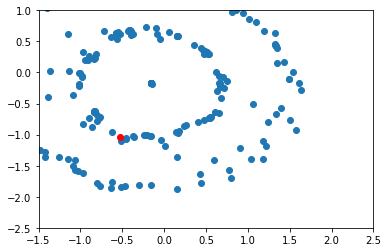

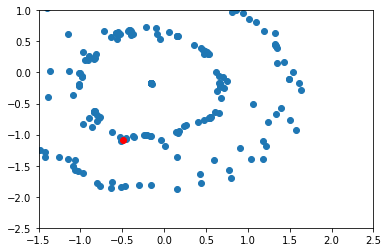

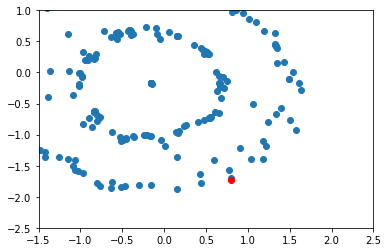

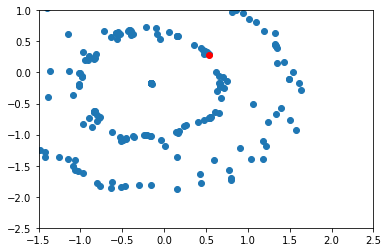

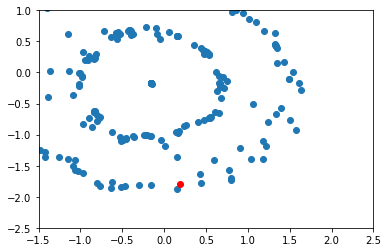

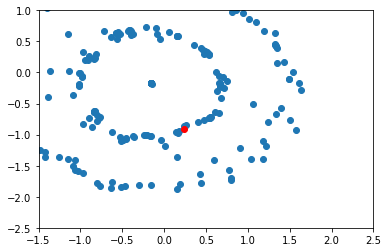

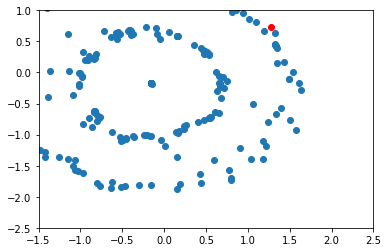

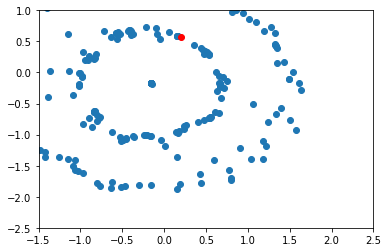

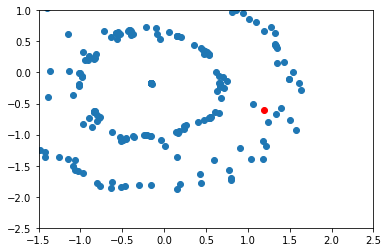

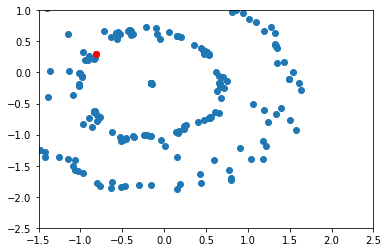

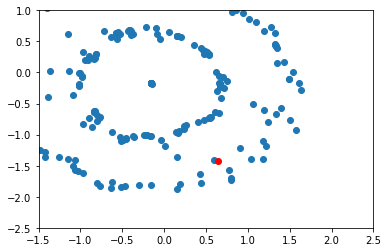

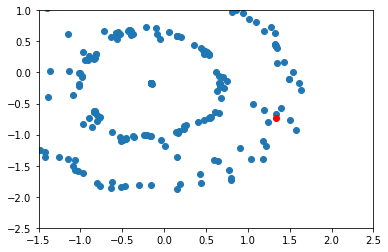

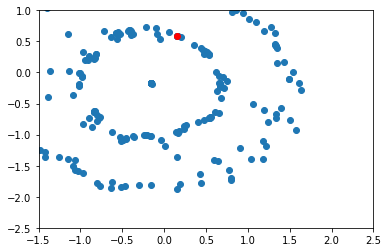

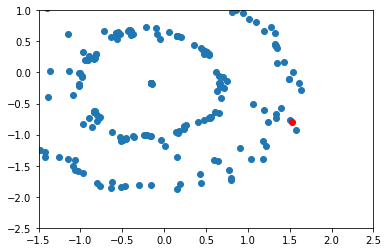

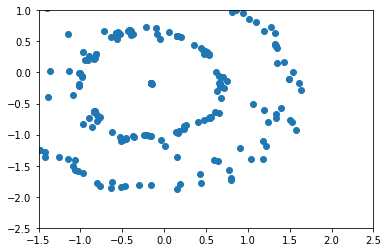

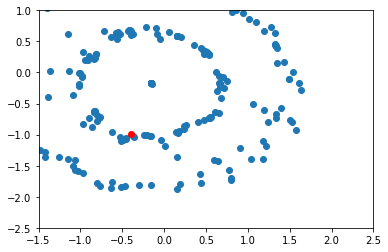

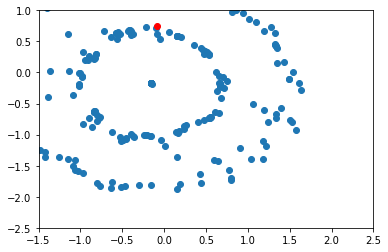

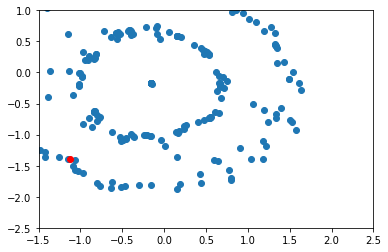

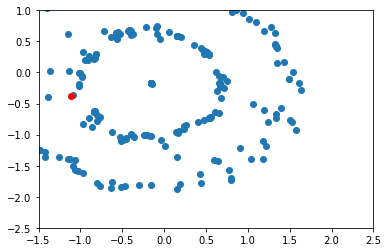

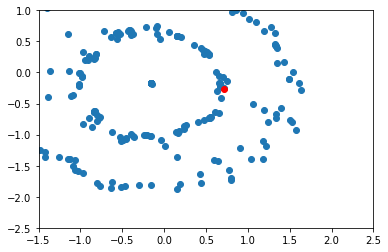

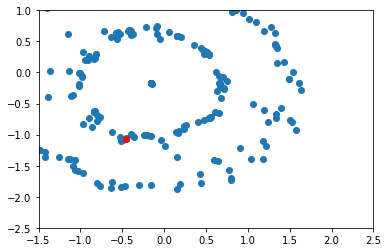

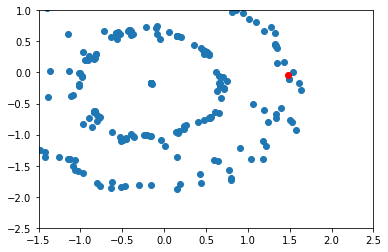

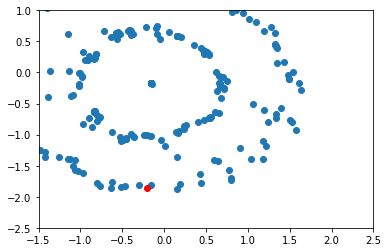

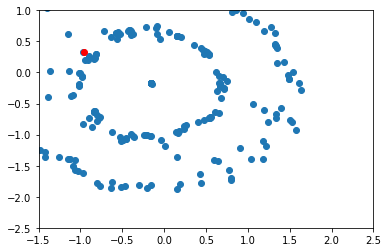

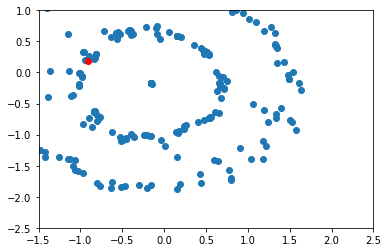

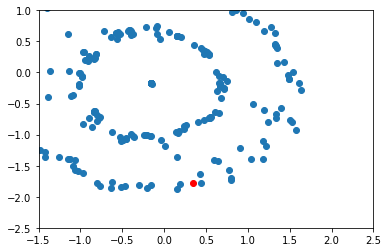

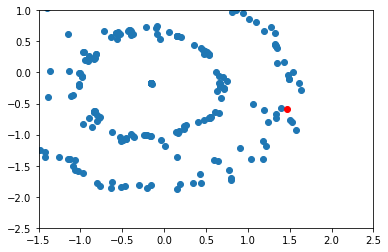

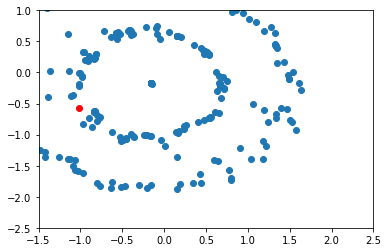

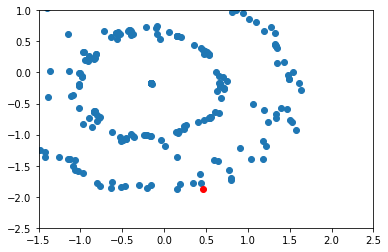

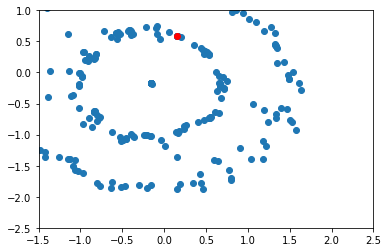

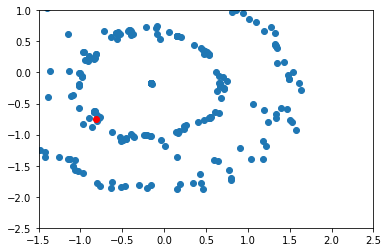

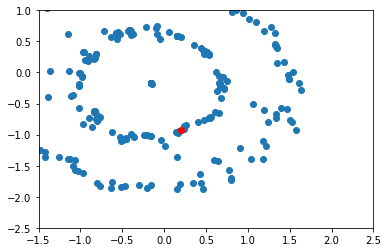

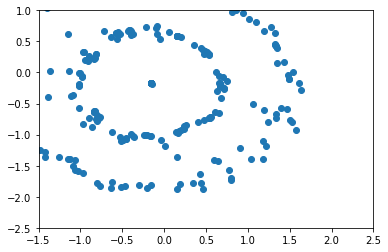

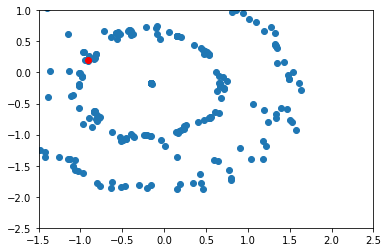

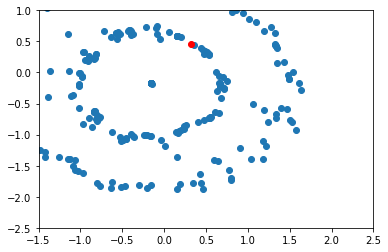

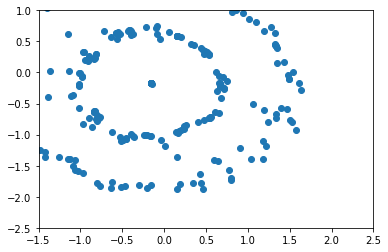

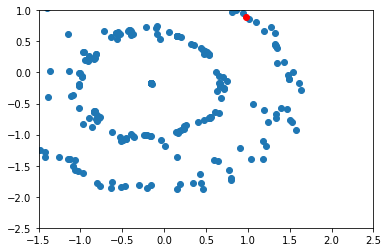

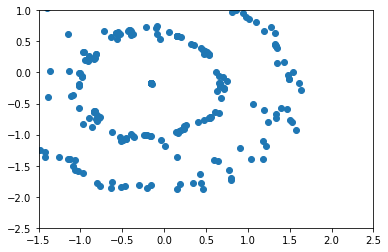

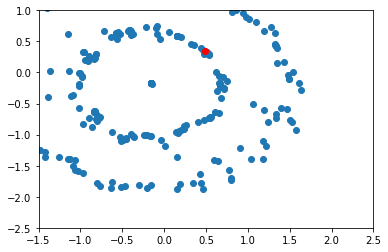

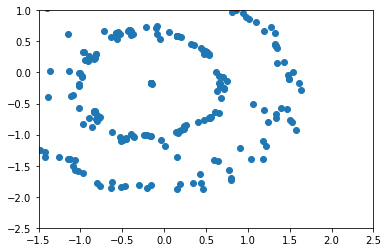

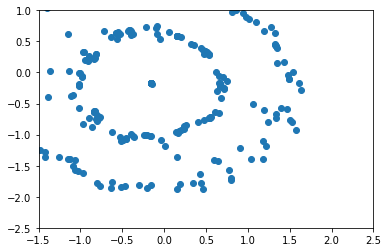

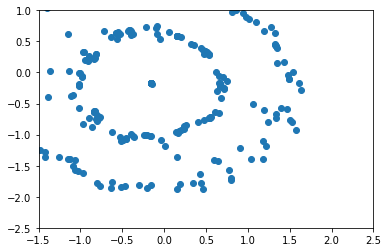

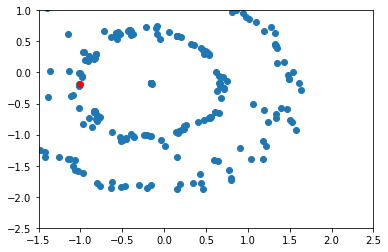

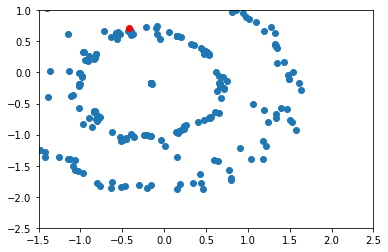

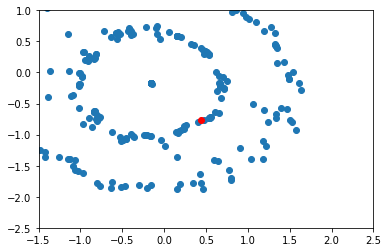

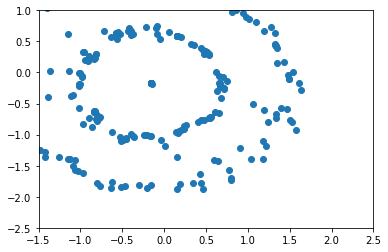

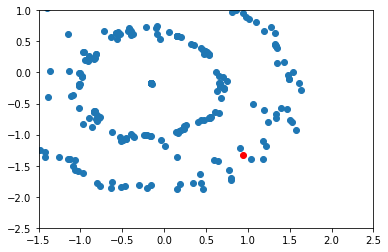

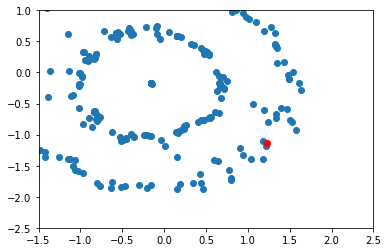

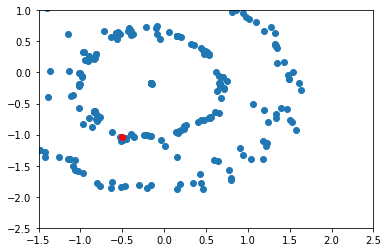

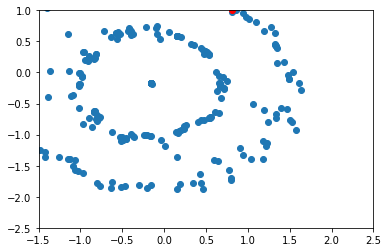

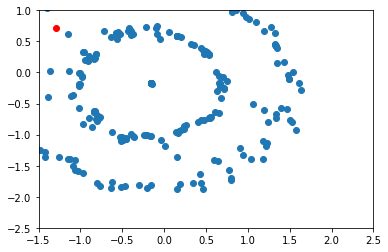

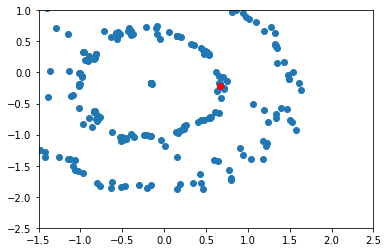

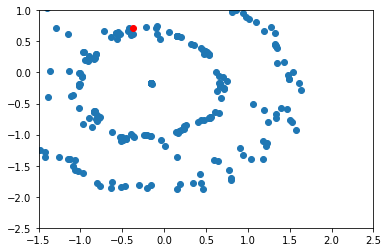

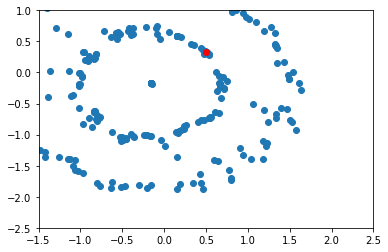

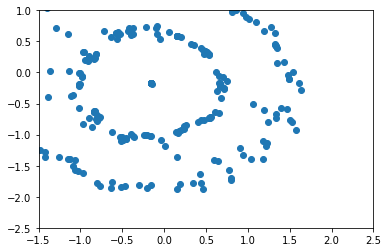

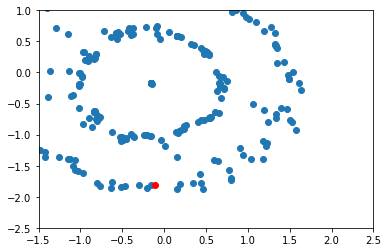

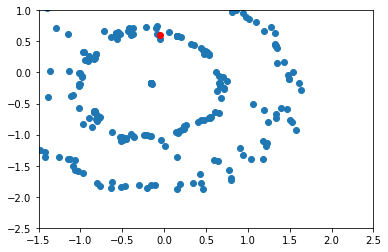

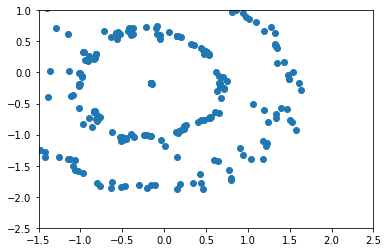

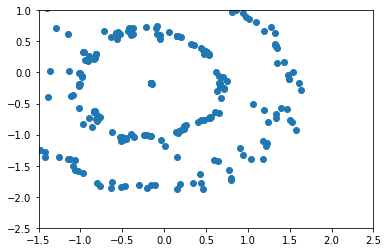

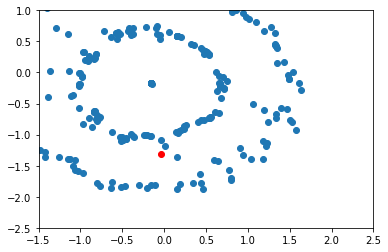

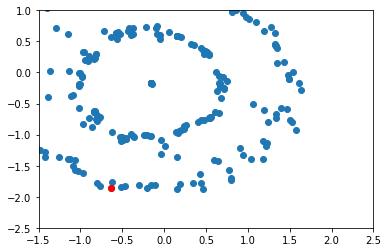

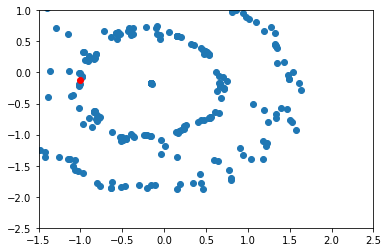

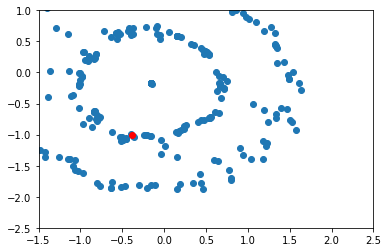

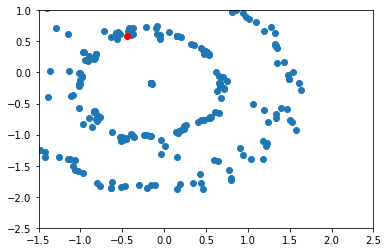

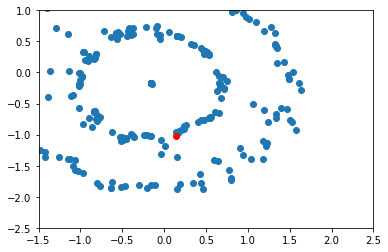

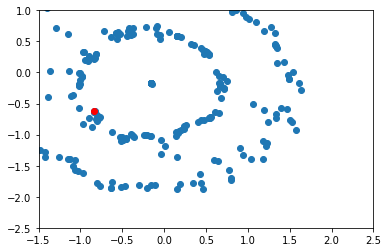

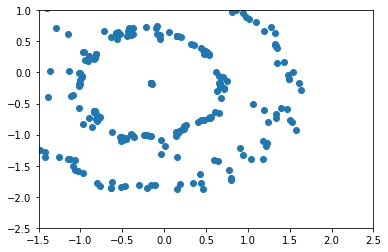

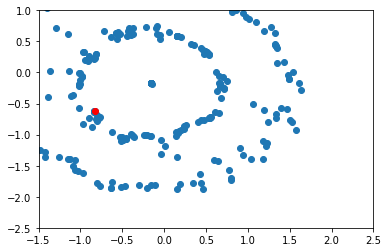

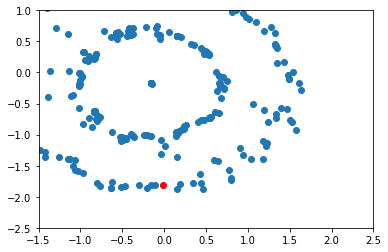

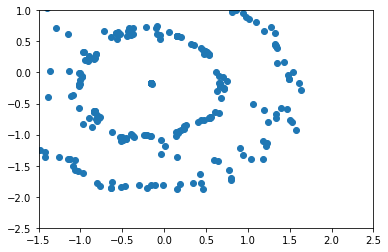

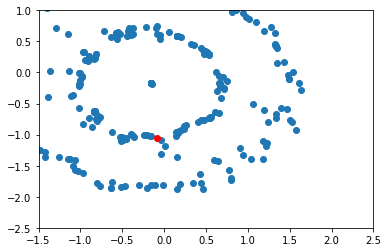

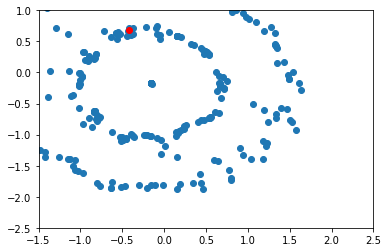

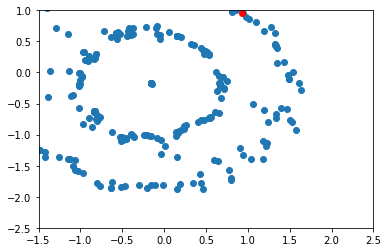

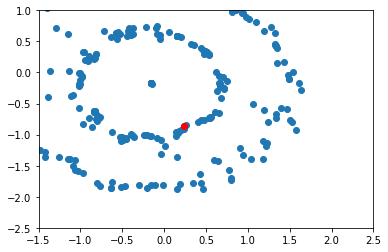

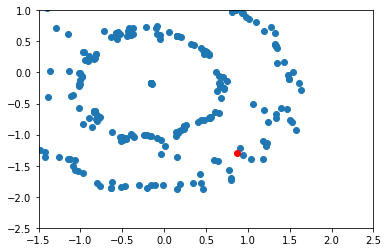

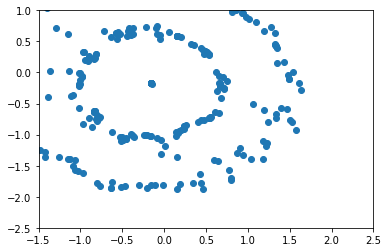

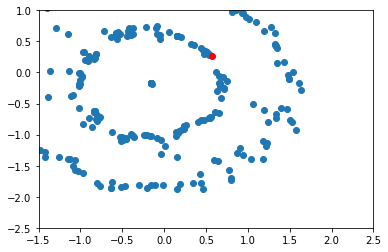

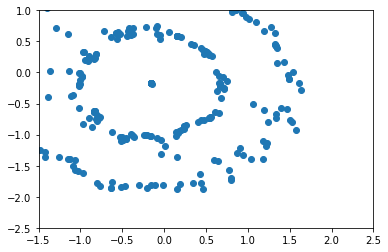

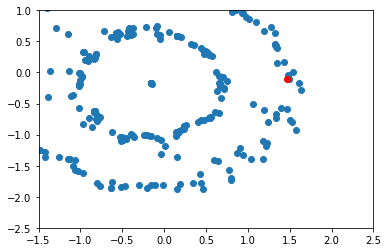

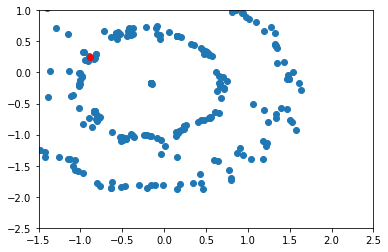

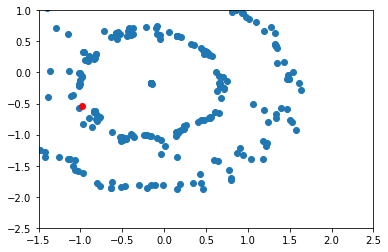

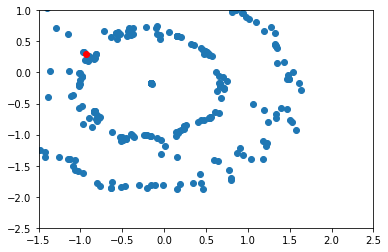

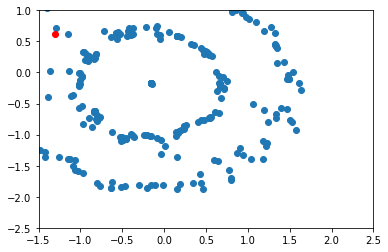

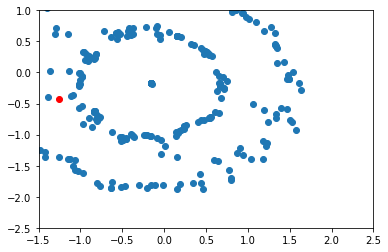

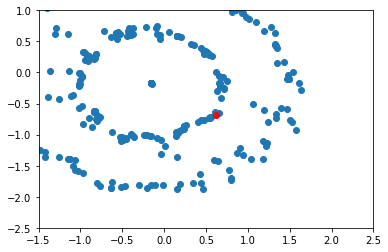

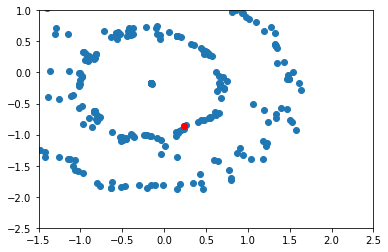

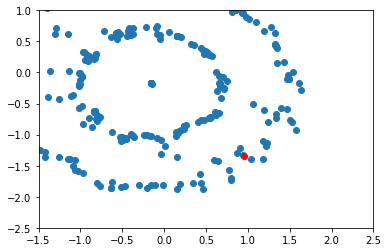

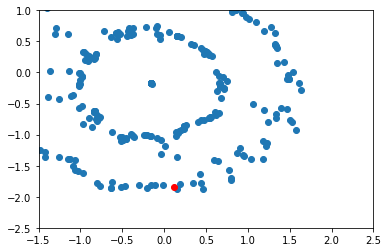

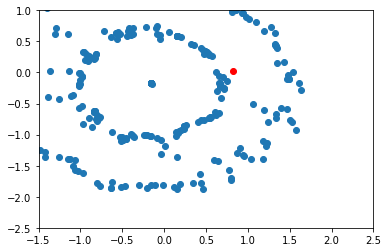

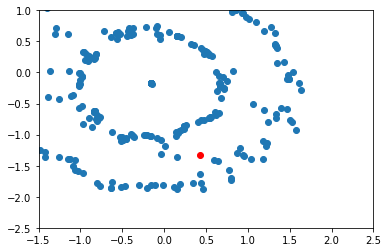

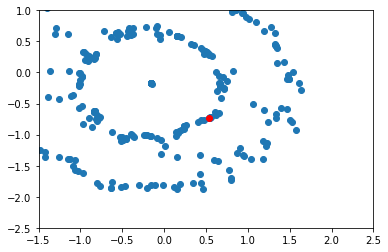

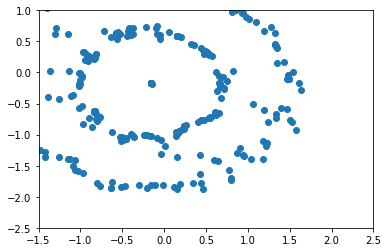

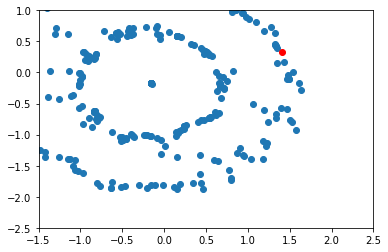

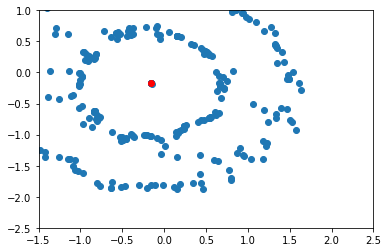

In [29]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation

img = [] # some array of images

for i in range(X_embedded.shape[0]):
    fig = plt.figure()
    plt.scatter(X_embedded[:i,0], X_embedded[:i,1])
    plt.scatter(X_embedded[i,0], X_embedded[i,1],c= "r")
    plt.xlim(-1.5,2.5)
    plt.ylim(-2.5,1)
    img.append(fig2img(fig))
 

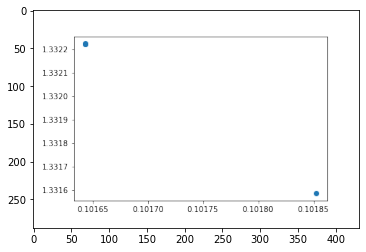

In [28]:
plt.imshow(img[4])

Using matplotlib backend: TkAgg


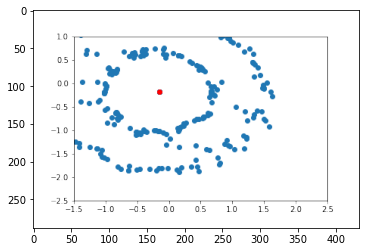

In [30]:
%matplotlib

fig = plt.figure()
viewer = fig.add_subplot(111)
plt.ion() # Turns interactive mode on (probably unnecessary)
fig.show() # Initially shows the figure

for i in range(len(img)):
    viewer.clear() # Clears the previous image
    viewer.imshow(img[i]) # Loads the new image
    plt.pause(.01) # Delay in seconds
    fig.canvas.draw() # Draws the image to the screen